# Define some helper functions for packaging the dataframe

In [1]:
# import libraries

import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from scipy.stats import entropy, pearsonr
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.preprocessing import label_binarize
from sklearn.utils import column_or_1d, check_consistent_length
from sklearn.metrics import mean_absolute_error
import random
import copy
#import uncertainty_metrics.numpy as um
#import tensorflow_probability as tfp
from tqdm import tqdm

sns.set_color_codes()
%matplotlib inline

sns.set(font="Calibri")
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,"xtick.labelsize":14,"ytick.labelsize":14,"legend.fontsize":14,"legend.title_fontsize":14})

In [2]:
# function for packaging pickels into dataframes
def reshape_mc_predictions(X):
    # change the shape from N * M to M * N

    X = np.array(X)
    new_list = []
    for index in range(0, len(X[0])):
        new_row = X[:, index, None]
        new_list.append(new_row)

    #print("new len", len(new_list), len(new_list[0]))
    return new_list

def package_pickle(X, y, labels, run_name):

    #print(np.array(X).shape, np.array(y).shape, np.array(labels).shape)

    # get all the pickels into a dataframe for easier processing
    run_names = [run_name] * len(X)
    labels = [labels] * len(X)

    #print(len(X), len(y), len(labels), len(run_names))
    dataframe_dict = []

    for index in range(0, len(X)):
        dataframe_dict.append({'mc_predictions': X[index], 'y_true': y[index], 'labels': labels[index], 'run_name': run_name})

    df = pd.DataFrame(data=dataframe_dict)
    #print(df.head())
    return df

def package_pickles(pickle_paths):

    df = pd.DataFrame([], columns=["mc_predictions", "y_true", "labels", "run_name", "trip_method", "method"])

    for item in tqdm(pickle_paths):
        #print(item)
        X_path = item["X_path"]
        y_val_path = item["y_val_path"]
        labels_path = item["labels_path"]
        run_name = item["run_name"]
        trip_method = item["trip_method"]
        method = item["method"]
        data_shift = item["data_shift"]
        #print(run_name)
        X = pickle.load(open(X_path, "rb"))
        y_val = pickle.load(open(y_val_path, "rb"))

        with open(labels_path) as f:
            labels = f.readlines()

        # you may also want to remove whitespace characters like `\n` at the end of each line
        labels = [x.strip() for x in labels]

        X = reshape_mc_predictions(X)
        df2 = package_pickle(X, y_val, labels, run_name)
        df2["trip_method"] = trip_method
        df2["method"] = method
        df2["data_shift"] = data_shift
        df = df.append(df2)

    return df

def generate_derived_properties(df):
    properties = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print(index)
        y = row['y_true'] #np.expand_dims(y_true[patch_index], 0)
        # predict stochastic dropout model T times - number of prediction runs
        p_hat = []
        #print(len(y))
        #print(len(row['mc_predictions']), len(row['mc_predictions'][0]))
        #print(len(df.loc[index,'mc_predictions']), len(df.loc[index, 'mc_predictions'][0]))

        for t in range(len(row['mc_predictions'])):
            # print(model.predict(image))
            p_hat.append(row['mc_predictions'][t])
        p_hat = np.array(p_hat)
        #p_hat = p_hat[0]

        # p_hat = result
        # mean prediction
        prediction_dist = np.mean(p_hat, axis=0)[0]
        #print("dist", len(prediction_dist))
        variance = np.var(p_hat, axis=0)[0]
        std_dev = np.std(p_hat, axis=0)[0]
        # threshold mean prediction
        # prediction = np.where(prediction > 0.5, 1, 0)

        # estimate uncertainties (eq. 4 )
        # eq.4 in https://openreview.net/pdf?id=Sk_P2Q9sG
        # see https://github.com/ykwon0407/UQ_BNN/issues/1
        aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)[0]
        epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2

        predicted_index = np.argmax(prediction_dist)
        y_index = np.argmax(y)
        #print("index", predicted_index)
        prediction_score = prediction_dist[predicted_index]
        prediction_label = row['labels'][predicted_index]
        true_label = row['labels'][y_index]
        prediction_epistemic = variance[predicted_index]
        prediction_aleatoric = aleatoric[predicted_index]

        correct_prediction = (predicted_index == y_index)
        #correct_prediction = y[predicted_index]
        entropy_val = entropy(prediction_dist)

        part = np.partition(-prediction_dist, 1, axis=0)
        margin = -part[0] + part[1]

        properties.append(
            [np.squeeze(prediction_dist),
             np.squeeze(variance),
             np.squeeze(aleatoric),
             prediction_score,
             prediction_label,
             true_label,
             prediction_epistemic,
             prediction_aleatoric,
             correct_prediction,
             predicted_index,
             y_index,
             entropy_val,
             margin,
             y
            ])

    properties = np.array(properties)
    df['prediction_dist'] = properties[:, 0, None]
    df['epistemic'] = properties[:, 1, None]
    df['aleatoric'] = properties[:, 2, None]
    df['prediction_score'] = properties[:, 3, None]
    df['prediction_label'] = properties[:, 4, None]
    df['true_label'] = properties[:, 5, None]
    df['prediction_epistemic'] = properties[:, 6, None]
    df['prediction_aleatoric'] = properties[:, 7, None]
    df['correct_prediction'] = properties[:, 8, None]
    df['prediction_index'] = properties[:, 9, None]
    df['true_index'] = properties[:, 10, None]
    df['entropy'] = properties[:, 11, None]
    df['margin'] = properties[:, 12, None]
    df['y_true'] = properties[:, 13, None]

    #print(properties)

    return df

# Load the inference runs and package them into a dataframe for plotting

In [3]:
pickle_paths = []

# load vanillas
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Vanilla " + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "Single",
        "data_shift": "Test",
        }
   )

# load vanilla trips
for i in range(1, 11):

    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "Single",
        "data_shift": "Trip 2 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "Single",
        "data_shift": "Trip 3 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "Single",
        "data_shift": "Trip 1 Towed",
        }
   )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Vanilla" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "Single",
        "data_shift": "Trip 3 Towed",
        }
   )

# load vanillas
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Vanilla Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Single",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Vanilla Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-vanilla-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Single",
            "data_shift": "Colour %s" % str(col),
            }
       )

# load bayes
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Bayes " + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "MC Dropout",
        "data_shift": "Test",
        }
   )

# load bayes trips
for i in range(1, 11):

    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "MC Dropout",
        "data_shift": "Trip 2 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "MC Dropout",
        "data_shift": "Trip 3 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "MC Dropout",
        "data_shift": "Trip 1 Towed",
        }
   )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Bayes" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "MC Dropout",
        "data_shift": "Trip 3 Towed",
        }
   )

# load bayes colour
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Bayes Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "MC Dropout",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Bayes Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-bayes-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "MC Dropout",
            "data_shift": "Colour %s" % str(col),
            }
       )

# load ensemble
for i in range(1, 11):
    pickle_paths.append(
       {
        "run_name": "6854 Test DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854",
        "method": "Ensemble",
           "data_shift": "Test",
        }
   )

# load ensemble trips
for i in range(1, 11):

    pickle_paths.append(
       {
        "run_name": "6854 Trip6999 DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6999-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6999-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6999",
        "method": "Ensemble",
        "data_shift": "Trip 2 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255 DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255",
        "method": "Ensemble",
        "data_shift": "Trip 3 Diver",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip6854SLO DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6854SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip6854SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 6854SLO",
        "method": "Ensemble",
        "data_shift": "Trip 1 Towed",
        }
    )

    pickle_paths.append(
       {
        "run_name": "6854 Trip7255SLO DESC2 Ensemble" + str(i),
        "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255SLO-inference%s.p" % str(i),
        "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-trip7255SLO-inferencey%s.p" % str(i),
        "labels_path": "labels.txt",
        "trip_method": "Dive 7255SLO",
        "method": "Ensemble",
        "data_shift": "Trip 3 Towed",
        }
   )


# load ensemble colour & blur
for i in range(1, 11):
    for col in range(1, 11):
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Ensemble Blur%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-blur%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-blur%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Ensemble",
            "data_shift": "Blur %s" % str(col),
            }
       )
        pickle_paths.append(
           {
            "run_name": "6854 Test DESC2 Ensemble Colour%s %s" % (str(col), str(i)),
            "X_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-colour%s-inference%s.p" % (str(col), str(i)),
            "y_val_path": "./data_DESC2_ensem/6854-test-GROUP_DESC2-ensemble-colour%s-inferencey%s.p" % (str(col), str(i)),
            "labels_path": "labels.txt",
            "trip_method": "Dive 6854",
            "method": "Ensemble",
            "data_shift": "Colour %s" % str(col),
            }
       )

df = package_pickles(pickle_paths)
df = generate_derived_properties(df)


100%|██████████| 2722980/2722980 [15:03<00:00, 3014.53it/s]
<ipython-input-2-14d2d0f5f94a>:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  properties = np.array(properties)


# Load saved preprocessed dataframe from disk

In [3]:
#df.to_pickle("saved_preprocessed_df.p")
df = pd.read_pickle("saved_preprocessed_df.p")

In [4]:
df["shift_category"] = ""

df.loc[(df['data_shift'].str.contains("Trip")), 'shift_category'] = "Real"
df.loc[(df['data_shift'].str.contains("Test")), 'shift_category'] = "Real"

df.loc[(df['data_shift'].str.contains("Col")), 'shift_category'] = "Colour"
df.loc[(df['data_shift'].str.contains("Blur")), 'shift_category'] = "Blur"

# Some helper functions for ECE, F1

In [16]:

#### This is directly from sci kit code, added the ece calc line in here to speed up the process
def custom_calibration_curve(y_true, y_prob, *, normalize=False, n_bins=5,
                      strategy='uniform'):
    """Compute true and predicted probabilities for a calibration curve.

    The method assumes the inputs come from a binary classifier, and
    discretize the [0, 1] interval into bins.

    Calibration curves may also be referred to as reliability diagrams.

    Read more in the :ref:`User Guide <calibration>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets.

    y_prob : array-like of shape (n_samples,)
        Probabilities of the positive class.

    normalize : bool, default=False
        Whether y_prob needs to be normalized into the [0, 1] interval, i.e.
        is not a proper probability. If True, the smallest value in y_prob
        is linearly mapped onto 0 and the largest one onto 1.

    n_bins : int, default=5
        Number of bins to discretize the [0, 1] interval. A bigger number
        requires more data. Bins with no samples (i.e. without
        corresponding values in `y_prob`) will not be returned, thus the
        returned arrays may have less than `n_bins` values.

    strategy : {'uniform', 'quantile'}, default='uniform'
        Strategy used to define the widths of the bins.

        uniform
            The bins have identical widths.
        quantile
            The bins have the same number of samples and depend on `y_prob`.

    Returns
    -------
    prob_true : ndarray of shape (n_bins,) or smaller
        The proportion of samples whose class is the positive class, in each
        bin (fraction of positives).

    prob_pred : ndarray of shape (n_bins,) or smaller
        The mean predicted probability in each bin.

    References
    ----------
    Alexandru Niculescu-Mizil and Rich Caruana (2005) Predicting Good
    Probabilities With Supervised Learning, in Proceedings of the 22nd
    International Conference on Machine Learning (ICML).
    See section 4 (Qualitative Analysis of Predictions).

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.calibration import calibration_curve
    >>> y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
    >>> y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9,  1.])
    >>> prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)
    >>> prob_true
    array([0. , 0.5, 1. ])
    >>> prob_pred
    array([0.2  , 0.525, 0.85 ])
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    if normalize:  # Normalize predicted values into interval [0, 1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    elif y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError("y_prob has values outside [0, 1] and normalize is "
                         "set to False.")

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Only binary classification is supported. "
                         "Provided labels %s." % labels)
    y_true = label_binarize(y_true, classes=labels)[:, 0]

    if strategy == 'quantile':  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
        bins[-1] = bins[-1] + 1e-8
    elif strategy == 'uniform':
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    else:
        raise ValueError("Invalid entry to 'strategy' input. Strategy "
                         "must be either 'quantile' or 'uniform'.")

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    ece = np.sum(np.abs(prob_true - prob_pred) * (bin_total[nonzero] / len(y_true)))

    return prob_true, prob_pred, ece

def package_and_plot_calibration_curve_withvariance(df):
    fraction_of_positives = []
    mean_predicted_values = []
    data_shifts = []
    run_names = []
    clf_scores = []
    plot_labels = []
    ece_scores = []
    methods = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    ece_scores_old = []

    pbar = tqdm(df.run_name.unique())

    #for data_shift in df.data_shift.unique():
    for run_name in pbar:
        pbar.set_description("Processing run name %s" % run_name)

        method = df[df['run_name'] == run_name]['method'].values[0]

        prediction_dists = df[df['run_name'] == run_name]['prediction_score'].values
        prediction_dists = np.asarray(list(prediction_dists), dtype=np.float32)
        y_true_binary = df[df['run_name'] == run_name]['correct_prediction'].values
        y_true_binary = np.asarray(list(y_true_binary), dtype=np.float32)

        y_true = df[df['run_name'] == run_name]['true_index'].values

        y_true = np.asarray(list(y_true), dtype=np.float32)
        data_shift = df[df['run_name'] == run_name]['data_shift'].values[0]

        true_labels = df[df['run_name'] == run_name]['y_true'].values
        true_labels = np.asarray(list(true_labels), dtype=np.int32)
        prediction_probs = df[df['run_name'] == run_name]['prediction_dist'].values
        prediction_probs = np.asarray(list(prediction_probs), dtype=np.float32)

        prediction_dists = prediction_dists.astype(float)
        y_true = y_true.astype(float)

        fraction_of_positive, mean_predicted_value, ece = custom_calibration_curve(y_true_binary, prediction_dists, n_bins=5, strategy='quantile')
        clf_score = []
        #old_ece = expected_calibration_error(y_true, prediction_probs,5)

        prediction_indexes = df[df['run_name'] == run_name]['prediction_index'].values
        true_indexes = df[df['run_name'] == run_name]['true_index'].values
        prediction_indexes = prediction_indexes.astype(int)
        true_indexes = true_indexes.astype(int)
        '''
        if class_index == None:
            f1 = f1_score(true_indexes, prediction_indexes, average='weighted')
            precision = precision_score(true_indexes, prediction_indexes, average='weighted')
            recall = recall_score(true_indexes, prediction_indexes, average='weighted')
        else:
            f1 = f1_score(true_indexes, prediction_indexes, labels=[class_index])
            precision = precision_score(true_indexes, prediction_indexes, labels=[class_index])
            recall = recall_score(true_indexes, prediction_indexes, labels=[class_index])
        '''
        #ece = 0

        for index, item in enumerate(fraction_of_positive):
            fraction_of_positives.append(fraction_of_positive[index])
            mean_predicted_values.append(mean_predicted_value[index])
            data_shifts.append(data_shift)
            run_names.append(run_name)
            clf_scores.append(clf_score)
            plot_labels.append(data_shift)
            ece_scores.append(ece)
            methods.append(method)
            #ece_scores_old.append(old_ece)

    mean_predicted_values = np.round(mean_predicted_values, 1)

    plot_df = pd.DataFrame(data={"fraction_of_positives": fraction_of_positives,
                                 "mean_predicted_values": mean_predicted_values,
                                 "data_shifts": data_shifts,
                                 "run_names": run_names,
                                 "clf_scores": clf_scores,
                                 "plot_labels": plot_labels,
                                 "ece_scores": ece_scores,
                                 #"old_ece_scores": ece_scores_old,
                                 "methods": methods})

    return plot_df

def calculate_f1_scores(df):
    df_copy = df.copy()
    f1s = []
    f1_dict = {}

    with open("labels.txt") as f:
        labels = f.readlines()
    labels = [x.strip() for x in labels]

    df_copy["f1_global"] = np.nan
    df_copy["f1_labels"] = np.nan
    df_copy["precision_global"] = np.nan
    df_copy["precision_labels"] = np.nan
    df_copy["recall_global"] = np.nan
    df_copy["recall_labels"] = np.nan

    prediction_indexes = df_copy.prediction_index.unique()

    pbar = tqdm(df_copy.run_name.unique())

    results = []

    for run_name in pbar:

        pbar.set_description("Processing run name %s" % run_name)

        method = df[df['run_name'] == run_name]['method'].values[0]
        shift_category = df[df['run_name'] == run_name]['shift_category'].values[0]
        data_shift = df[df['run_name'] == run_name]['data_shift'].values[0]

        y_true = np.array(list(df_copy[df_copy['run_name'] == run_name]['y_true'].values)).astype(int)
        y_pred_p = np.array(list(df_copy[df_copy['run_name'] == run_name]['prediction_dist'].values))

        y_pred = np.zeros_like(y_pred_p)
        y_pred[np.arange(len(y_pred_p)), y_pred_p.argmax(1)] = 1

        #print(np.around(y_pred_p[0], decimals=2))
        #print(y_pred[0])

        f1_global = f1_score(y_true, y_pred, average='weighted')
        f1_labels = f1_score(y_true, y_pred, average=None)

        precision_global = precision_score(y_true, y_pred, average='weighted')
        precision_labels = precision_score(y_true, y_pred, average=None)

        recall_global = recall_score(y_true, y_pred, average='weighted')
        recall_labels = recall_score(y_true, y_pred, average=None)

        for pred_index in prediction_indexes:
            results.append({
                "run_name": run_name,
                "method": method,
                "shift_category": shift_category,
                "data_shift": data_shift,
                "f1_global": f1_global,
                "precision_global": precision_global,
                "recall_global": recall_global,
                "f1_labels": f1_labels[pred_index],
                "precision_labels": precision_labels[pred_index],
                "recall_labels": recall_labels[pred_index],
                "label": labels[pred_index]
            })
        '''
        df_copy.loc[df_copy['run_name'] == run_name, 'f1_global'] = f1_global
        df_copy.loc[df_copy['run_name'] == run_name, 'precision_global'] = precision_global
        df_copy.loc[df_copy['run_name'] == run_name, 'recall_global'] = recall_global

        for pred_index in prediction_indexes:
            df_copy.loc[(df_copy['run_name'] == run_name) & (df_copy['prediction_index'] == pred_index), 'f1_labels'] = f1_labels[pred_index]
            df_copy.loc[(df_copy['run_name'] == run_name) & (df_copy['prediction_index'] == pred_index), 'precision_labels'] = precision_labels[pred_index]
            df_copy.loc[(df_copy['run_name'] == run_name) & (df_copy['prediction_index'] == pred_index), 'recall_labels'] = recall_labels[pred_index]
        '''
    return pd.DataFrame(results)

def int_to_roman(num):
        val = [
            1000, 900, 500, 400,
            100, 90, 50, 40,
            10, 9, 5, 4,
            1
            ]
        syb = [
            "m", "cm", "d", "cd",
            "c", "xc", "l", "xl",
            "x", "ix", "v", "iv",
            "i"
            ]
        roman_num = ''
        i = 0
        while  num > 0:
            for _ in range(num // val[i]):
                roman_num += syb[i]
                num -= val[i]
            i += 1
        return roman_num

# Calculate F1 & recall metrics into a new DF for plots

In [6]:
f1_scores_df = calculate_f1_scores(df)

Processing run name 6854 Test DESC2 Vanilla Blur10 1:   9%|▉         | 68/750 [00:50<07:23,  1.54it/s] /home/mat/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mat/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Processing run name 6854 Test DESC2 Vanilla Blur10 4:  17%|█▋        | 128/750 [01:30<06:21,  1.63it/s]  /home/mat/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

# Calculate ECE & calibration curve metrics into new dataframes for plots

In [7]:
print("Processing global metrics")
global_metrics_df = package_and_plot_calibration_curve_withvariance(df)

per_label_metrics_df = {}
for label in df.prediction_label.unique():
    print("Processing label", label)
    label_df = df[df['prediction_label'] == label]
    label_plot_df = package_and_plot_calibration_curve_withvariance(label_df)
    per_label_metrics_df[label] = label_plot_df


Processing run name 6854 Test DESC2 Vanilla 1:   0%|          | 0/750 [00:00<?, ?it/s]

Processing global metrics


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [14:32<00:00,  1.16s/it]


Processing label HARD CORAL


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [05:37<00:00,  2.23it/s]


Processing label ALGAE


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [06:42<00:00,  1.86it/s]


Processing label ABIOTIC


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 735/735 [00:39<00:00, 18.78it/s]
Processing run name 6854 Test DESC2 Vanilla 1:   0%|          | 0/750 [00:00<?, ?it/s]

Processing label OTHER


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [01:16<00:00,  9.78it/s]
Processing run name 6854 Test DESC2 Vanilla 2:   0%|          | 0/750 [00:00<?, ?it/s]

Processing label SOFT CORAL


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [00:47<00:00, 15.70it/s]
Processing run name 6854 Test DESC2 Vanilla 5:   1%|          | 4/750 [00:00<00:19, 37.43it/s]

Processing label SPONGE


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [00:19<00:00, 39.23it/s]
Processing run name 6854 Test DESC2 Vanilla 6:   1%|          | 4/750 [00:00<00:19, 37.47it/s]

Processing label INDETERMINATE


Processing run name 6854 Test DESC2 Ensemble Colour10 10: 100%|██████████| 750/750 [00:21<00:00, 35.09it/s]


In [8]:
#global_metrics_df.to_pickle("global_metrics_df.p")

#for label in df.prediction_label.unique():
#    per_label_metrics_df[label].to_pickle("%s_metrics_df.p" % label)
'''
global_metrics_df = pd.read_pickle("global_metrics_df.p")

per_label_metrics_df = {}
for label in df.prediction_label.unique():
    per_label_metrics_df[label] = pd.read_pickle("%s_metrics_df.p" % label)
'''

global_metrics_df["shift_category"] = ""

global_metrics_df.loc[(global_metrics_df['data_shifts'].str.contains("Trip")), 'shift_category'] = "Real"
global_metrics_df.loc[(global_metrics_df['data_shifts'].str.contains("Test")), 'shift_category'] = "Real"

global_metrics_df.loc[(global_metrics_df['data_shifts'].str.contains("Col")), 'shift_category'] = "Colour"
global_metrics_df.loc[(global_metrics_df['data_shifts'].str.contains("Blur")), 'shift_category'] = "Blur"

for label in df.prediction_label.unique():
    per_label_metrics_df[label]["shift_category"] = ""

    per_label_metrics_df[label].loc[(per_label_metrics_df[label]['data_shifts'].str.contains("Trip")), 'shift_category'] = "Real"
    per_label_metrics_df[label].loc[(per_label_metrics_df[label]['data_shifts'].str.contains("Test")), 'shift_category'] = "Real"

    per_label_metrics_df[label].loc[(per_label_metrics_df[label]['data_shifts'].str.contains("Col")), 'shift_category'] = "Colour"
    per_label_metrics_df[label].loc[(per_label_metrics_df[label]['data_shifts'].str.contains("Blur")), 'shift_category'] = "Blur"

# Plot global ECE box plots

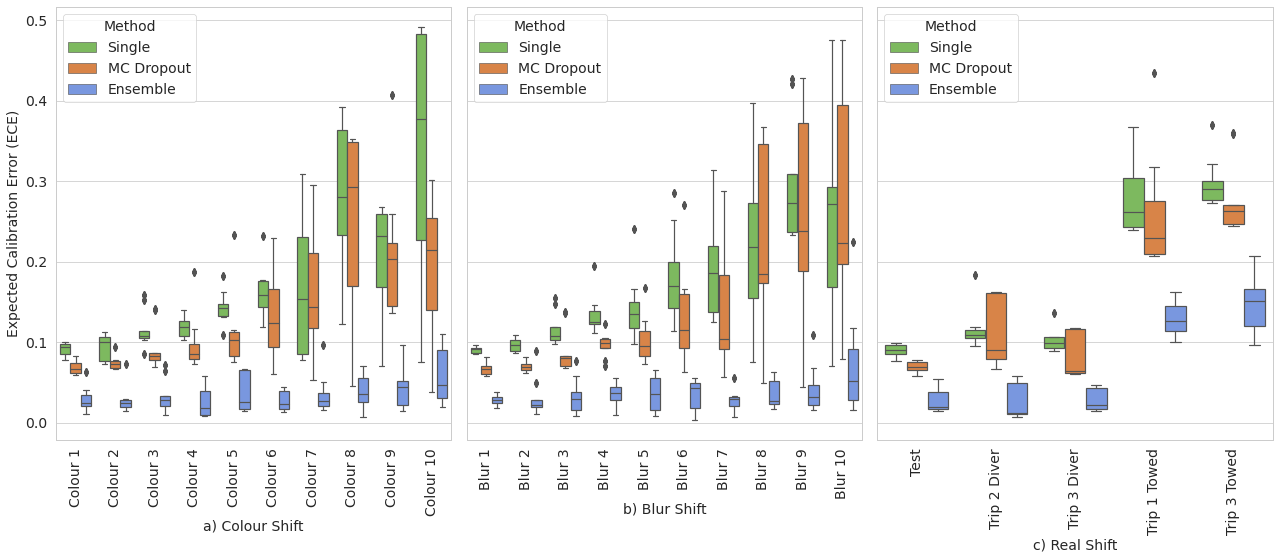

       methods data_shifts  ece_mean   ece_min   ece_max
0     Ensemble    Colour 1  0.028656  0.010535  0.063497
1     Ensemble   Colour 10  0.056161  0.019123  0.110585
2     Ensemble    Colour 2  0.028172  0.014486  0.073022
3     Ensemble    Colour 3  0.032926  0.009671  0.071407
4     Ensemble    Colour 4  0.025700  0.008285  0.057991
5     Ensemble    Colour 5  0.036042  0.014783  0.067252
6     Ensemble    Colour 6  0.026532  0.013776  0.044645
7     Ensemble    Colour 7  0.034616  0.015419  0.096190
8     Ensemble    Colour 8  0.037474  0.007719  0.070235
9     Ensemble    Colour 9  0.046235  0.015083  0.096000
10  MC Dropout    Colour 1  0.068561  0.058786  0.082689
11  MC Dropout   Colour 10  0.190790  0.038392  0.300988
12  MC Dropout    Colour 2  0.074232  0.066983  0.093891
13  MC Dropout    Colour 3  0.092018  0.069498  0.141460
14  MC Dropout    Colour 4  0.097738  0.073382  0.186906
15  MC Dropout    Colour 5  0.110018  0.075466  0.233272
16  MC Dropout    Colour 6  0.1

In [9]:
real = global_metrics_df[global_metrics_df['shift_category'] == "Real"]
colour = global_metrics_df[global_metrics_df['shift_category'] == "Colour"]
blur = global_metrics_df[global_metrics_df['shift_category'] == "Blur"]

'''

sns.set_palette('rainbow')

'''
# plot the boxplots in 3 cols
sns.set_style('whitegrid')
colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=colour, ax=axes[0], palette=colors)
sub.set(xlabel='a) Colour Shift', ylabel='Expected Calibration Error (ECE)')
axes[0].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=blur, ax=axes[1], palette=colors)
sub.set(xlabel='b) Blur Shift', ylabel='')
axes[1].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=real, ax=axes[2], palette=colors)
sub.set(xlabel='c) Real Shift', ylabel='')
axes[2].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

fig = plt.gcf()

#plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig("ece_boxplots.eps", format="eps", dpi=1000)
fig.savefig("ece_boxplots.pdf", format="pdf", dpi=1000)


# calculate and print numerical values that are in the plot for the results section
grouped_multiple = colour.groupby(['methods', 'data_shifts']).agg({'ece_scores': ['mean', 'min', 'max']})
grouped_multiple.columns = ['ece_mean', 'ece_min', 'ece_max']
grouped_multiple = grouped_multiple.reset_index()
print( grouped_multiple )

agg_func_describe = {'ece_scores': ['describe']}
grouped_multiple = colour.groupby(['methods', 'data_shifts']).agg(agg_func_describe).round(2)
print(grouped_multiple)

agg_func_describe = {'ece_scores': ['describe']}
grouped_multiple = blur.groupby(['methods', 'data_shifts']).agg(agg_func_describe).round(2)
print(grouped_multiple)

agg_func_describe = {'ece_scores': ['describe']}
grouped_multiple = real.groupby(['methods', 'data_shifts']).agg(agg_func_describe).round(2)
print(grouped_multiple)

# Plot per label ece box plots

HARD CORAL


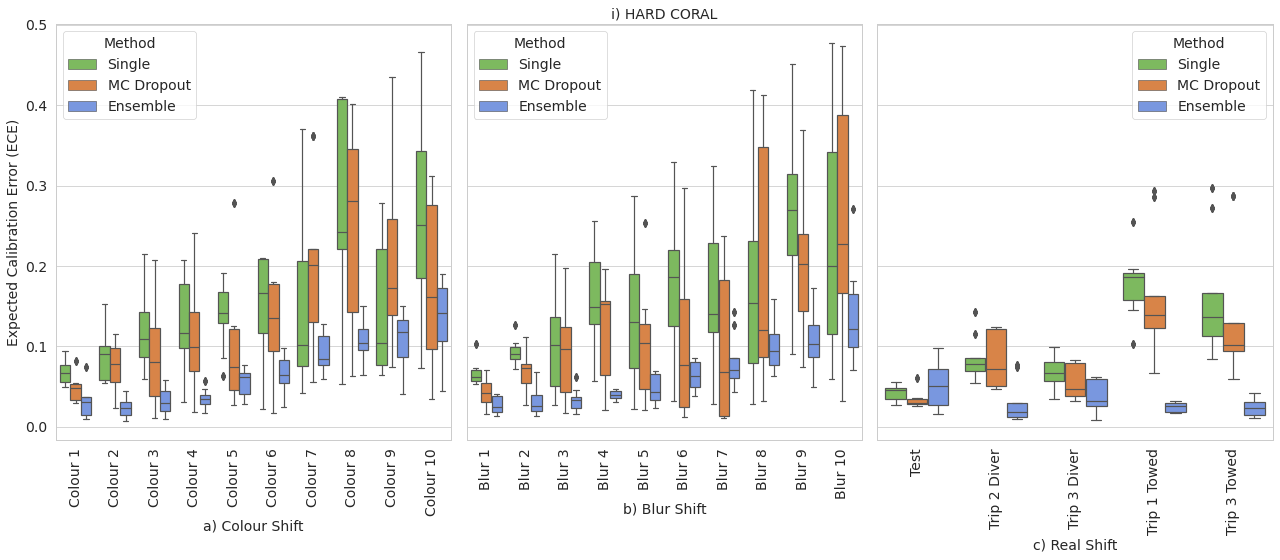

ALGAE


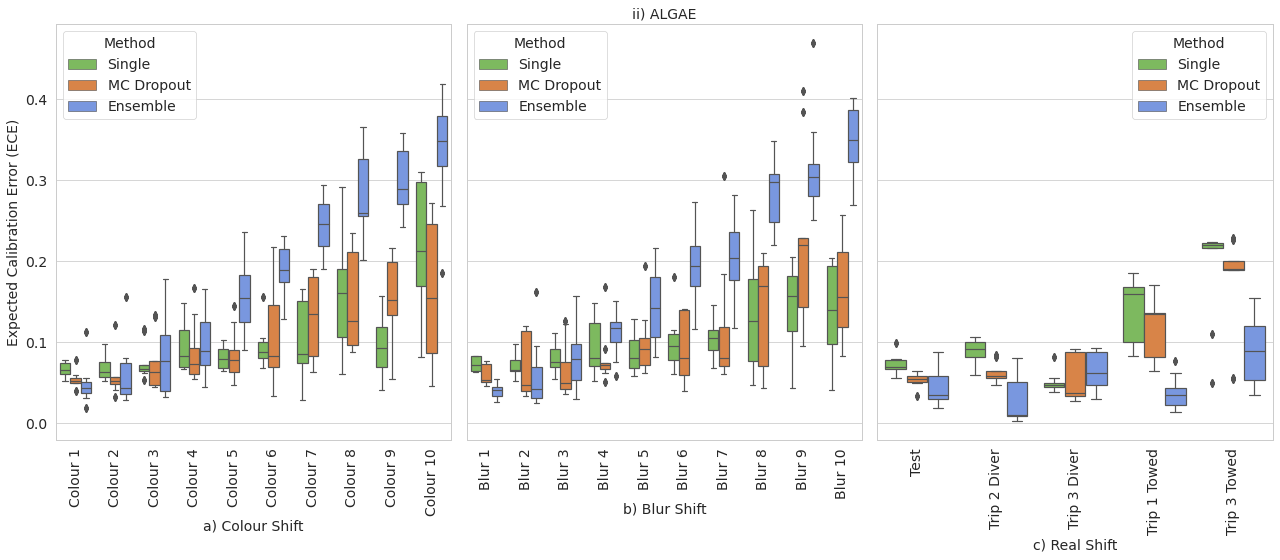

ABIOTIC


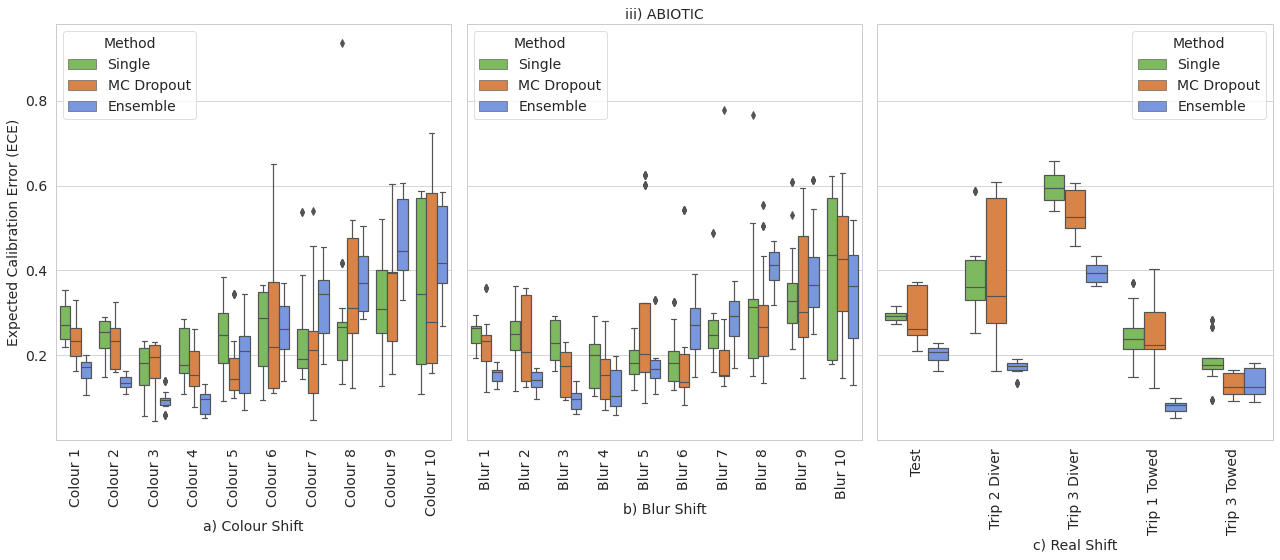

OTHER


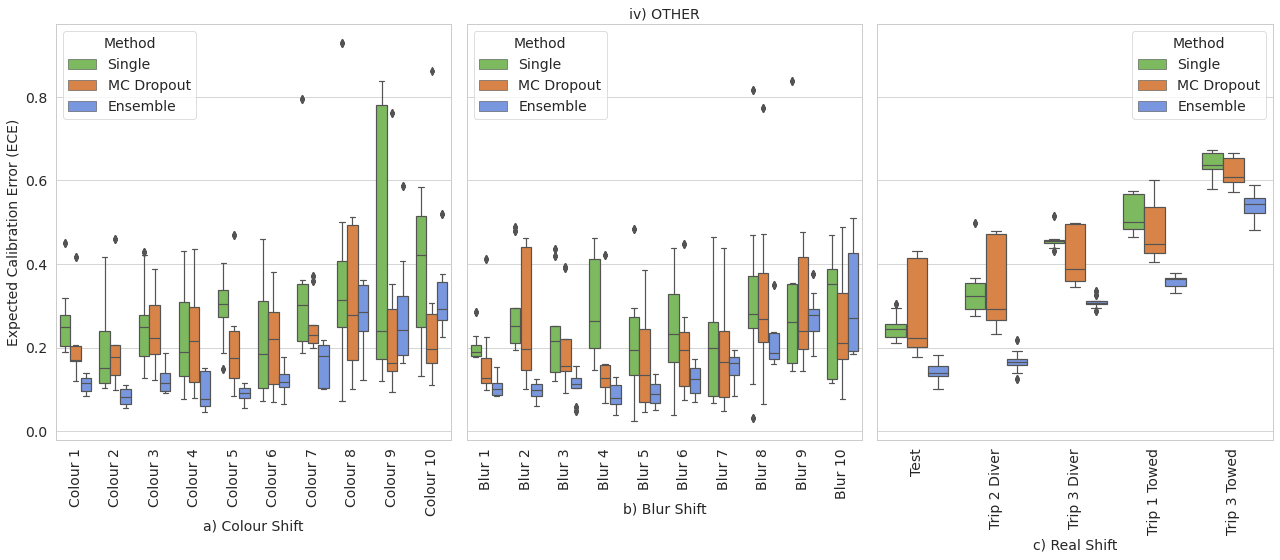

SOFT CORAL


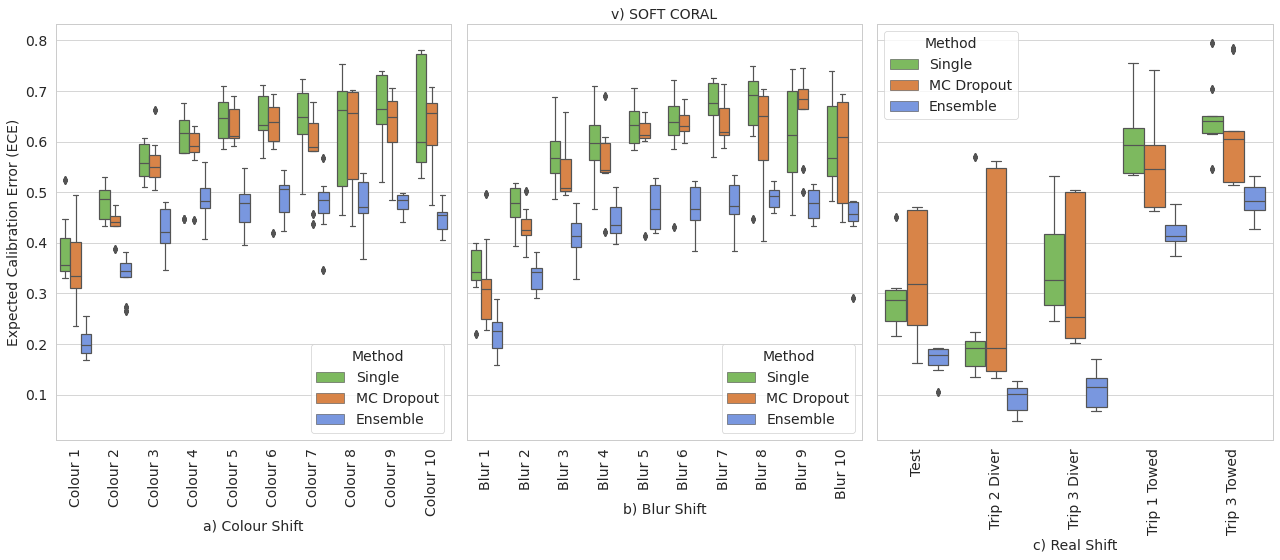

SPONGE


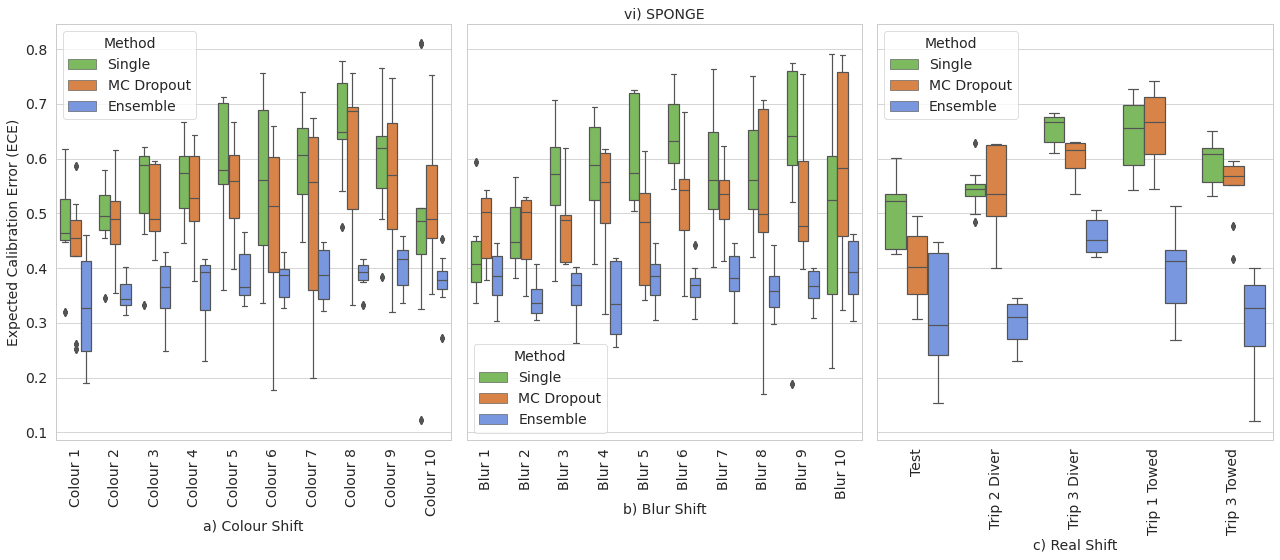

INDETERMINATE


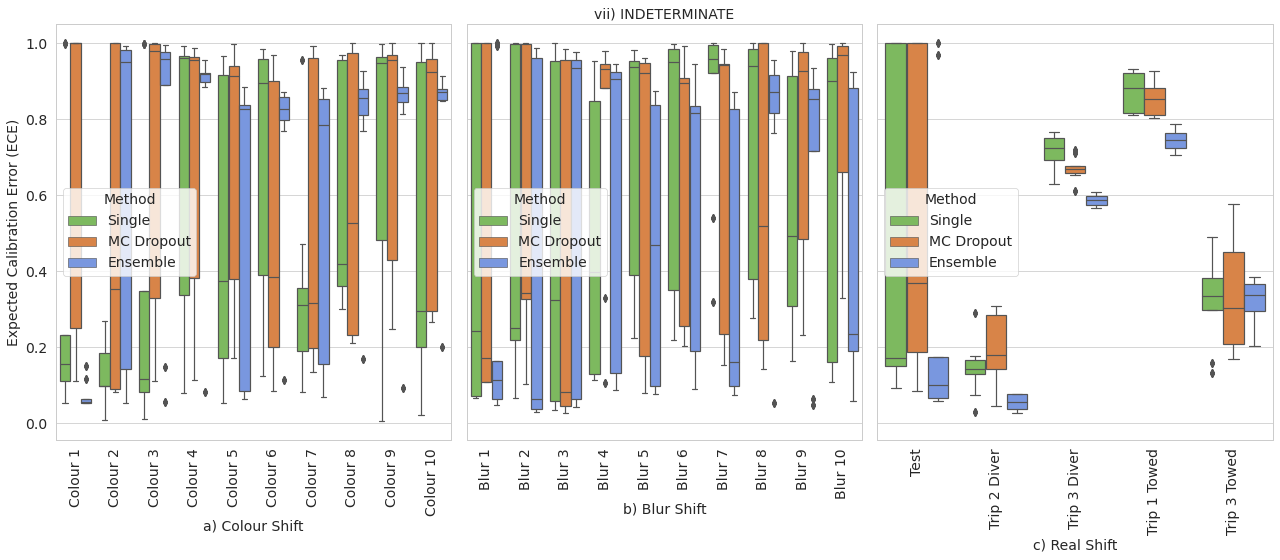

In [19]:
for index, label in enumerate(df.prediction_label.unique()):
#    per_label_metrics_df[label].to_pickle("%s_metrics_df.p" % label)
    print(label)
    label_metrics_df = per_label_metrics_df[label]

    real = label_metrics_df[label_metrics_df['shift_category'] == "Real"]
    colour = label_metrics_df[label_metrics_df['shift_category'] == "Colour"]
    blur = label_metrics_df[label_metrics_df['shift_category'] == "Blur"]

    '''

    sns.set_palette('rainbow')

    '''
    # plot the boxplots in 3 cols
    sns.set_style('whitegrid')
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

    sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=colour, ax=axes[0], palette=colors)
    sub.set(xlabel='a) Colour Shift', ylabel='Expected Calibration Error (ECE)')
    axes[0].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=blur, ax=axes[1], palette=colors)
    sub.set(xlabel='b) Blur Shift', ylabel='')
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_title(int_to_roman(index+1) + ") " + label)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shifts", y="ece_scores", hue="methods", data=real, ax=axes[2], palette=colors)
    sub.set(xlabel='c) Real Shift', ylabel='')
    axes[2].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")

    fig = plt.gcf()

    #plt.legend()
    plt.tight_layout()
    plt.show()
    #fig.savefig("ece_boxplots.eps", format="eps", dpi=1000)
    fig.savefig("ece_boxplots_%s.png" % label, format="png", dpi=1000)
    fig.savefig("ece_boxplots_%s.jpg" % label, format="jpg", dpi=150)

In [ ]:
import sys
from PIL import Image

list_im = ['Test1.jpg','Test2.jpg','Test3.jpg']

# creates a new empty image, RGB mode, and size 444 by 95
new_im = Image.new('RGB', (444,95))

for elem in list_im:
    for i in xrange(0,444,95):
        im=Image.open(elem)
        new_im.paste(im, (i,0))
new_im.save('test.jpg')

# Plot global calibration curves

<ipython-input-31-9b5e2f310003>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Shift Real


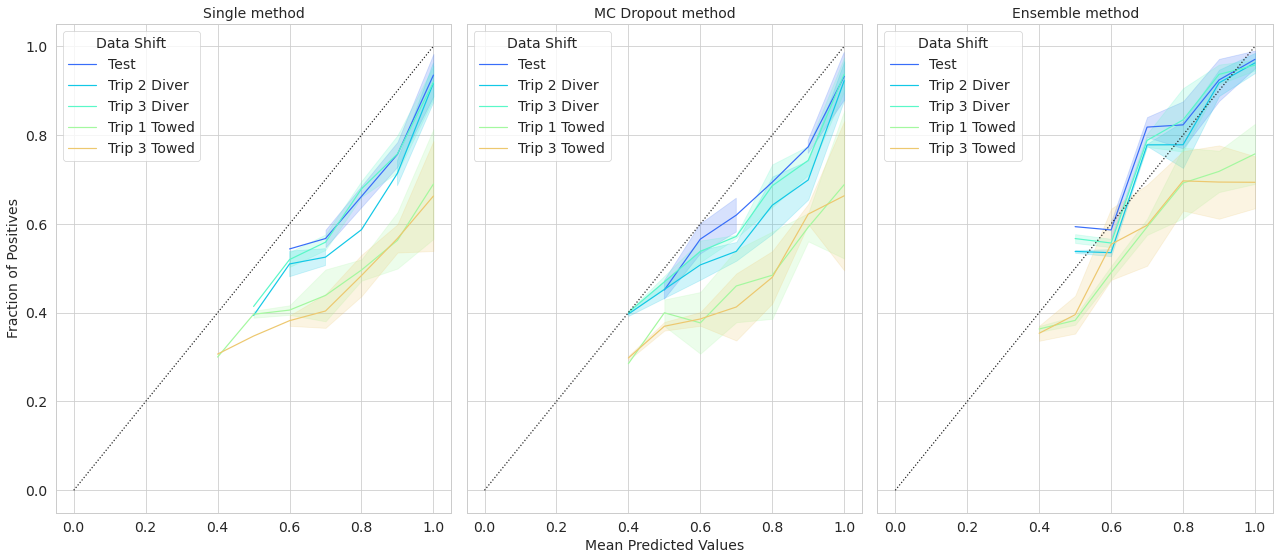

Single results
                                   fraction_of_positives          
                                                    mean       std
data_shifts  mean_predicted_values                                
Test         0.6                    0.543536             NaN      
             0.7                    0.566989              0.019676
             0.9                    0.756670              0.027854
             1.0                    0.935008              0.047928
Trip 1 Towed 0.4                    0.300057             NaN      
             0.5                    0.396463              0.007842
             0.6                    0.405835              0.010757
             0.7                    0.438867              0.058327
             0.8                    0.496048              0.023974
             0.9                    0.562921              0.063595
             1.0                    0.689615              0.123650
Trip 2 Diver 0.5                    0.393693   

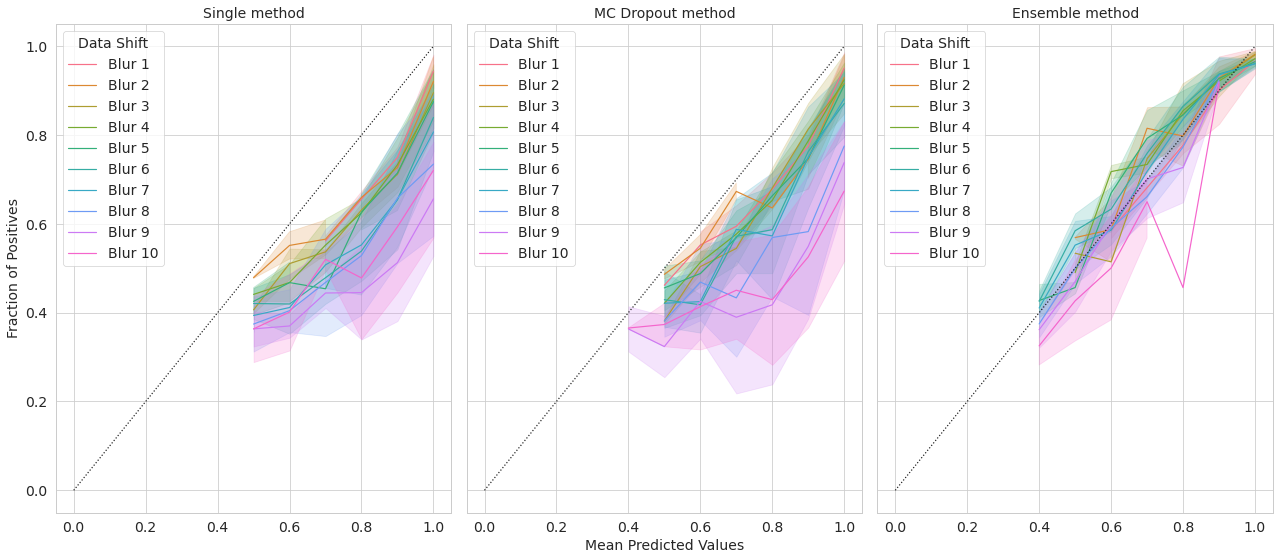

Single results
                                  fraction_of_positives          
                                                   mean       std
data_shifts mean_predicted_values                                
Blur 1      0.7                    0.562005              0.013222
            0.9                    0.749604              0.024036
            1.0                    0.943821              0.037454
Blur 10     0.5                    0.363530              0.074859
            0.6                    0.401385              0.086509
            0.7                    0.520103              0.023159
            0.8                    0.478179              0.137792
            0.9                    0.593405              0.147851
            1.0                    0.720427              0.151470
Blur 2      0.5                    0.478892              0.001866
            0.6                    0.551451              0.030714
            0.7                    0.565523              0.04

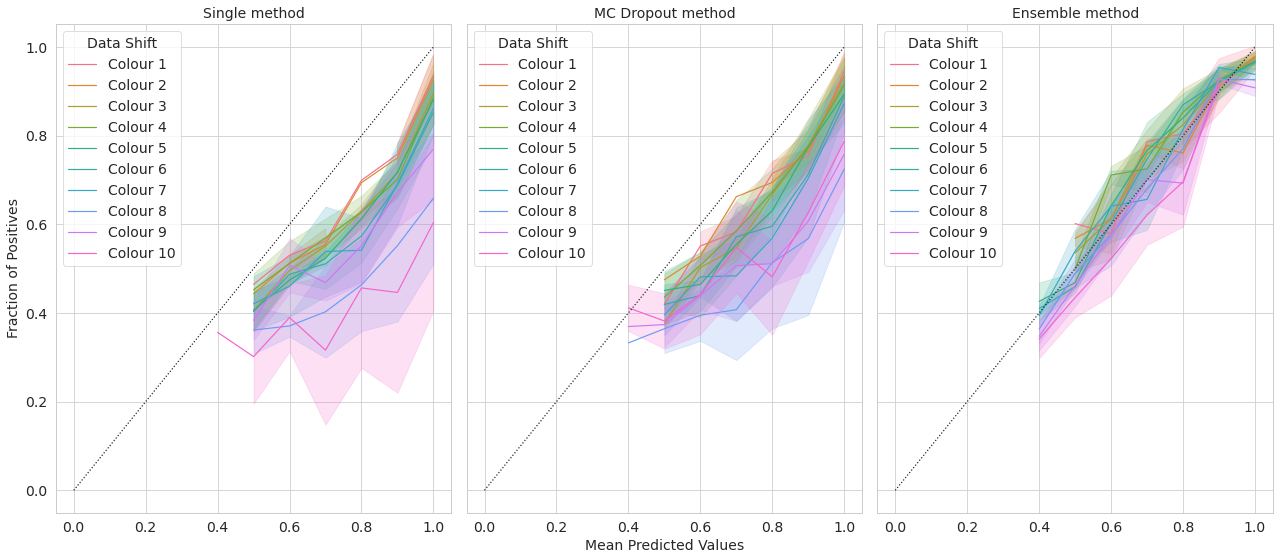

Single results
                                  fraction_of_positives          
                                                   mean       std
data_shifts mean_predicted_values                                
Colour 1    0.5                    0.464380             NaN      
            0.6                    0.530343             NaN      
            0.7                    0.562269              0.027853
            0.8                    0.699208             NaN      
            0.9                    0.757842              0.021669
            1.0                    0.935677              0.047085
Colour 10   0.4                    0.356201             NaN      
            0.5                    0.301545              0.106031
            0.6                    0.389622              0.075752
            0.7                    0.316095              0.168116
            0.8                    0.456464              0.180557
            0.9                    0.446321              0.22

In [31]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

for shift in global_metrics_df['shift_category'].unique():

    print("Shift", shift)

    b_plot_df = global_metrics_df[global_metrics_df['methods'].str.contains("MC Dropout")]
    e_plot_df = global_metrics_df[global_metrics_df['methods'].str.contains("Ensemble")]
    v_plot_df = global_metrics_df[global_metrics_df['methods'].str.contains("Single")]

    b_plot_df = b_plot_df[b_plot_df['shift_category'] == shift]
    e_plot_df = e_plot_df[e_plot_df['shift_category'] == shift]
    v_plot_df = v_plot_df[v_plot_df['shift_category'] == shift]

    sns.set_palette('rainbow')
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

    sub = sns.lineplot(data=v_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[0])
    sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    sub.set(xlabel='', ylabel='Fraction of Positives')
    sub.title.set_text('Single method')
    sub.get_legend().set_title("Data Shift")

    sub = sns.lineplot(data=b_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[1])
    sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    sub.set(xlabel='Mean Predicted Values', ylabel='Fraction of Positives')
    sub.title.set_text('MC Dropout method')
    sub.get_legend().set_title("Data Shift")

    sub = sns.lineplot(data=e_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[2])
    sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    sub.set(xlabel='', ylabel='Fraction of Positives')
    sub.title.set_text('Ensemble method')
    sub.get_legend().set_title("Data Shift")

    fig = plt.gcf()
    plt.tight_layout()
    plt.show()
    #fig.savefig("colour_shift_calibration.eps", format="eps", dpi=1000)
    fig.savefig("shift_calibration_%s.pdf" % shift, format="pdf", dpi=1000)
    fig.savefig("shift_calibration_%s.jpg" % shift, format="jpg", dpi=250)

    # out put the value tables for the results write up

    print("Single results")
    print(v_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

    print("MC Dropout results")
    print(b_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

    print("Ensemble results")
    print(e_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

# Per label calibration curves

<ipython-input-29-f978115785f1>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


HARD CORAL
Shift Colour


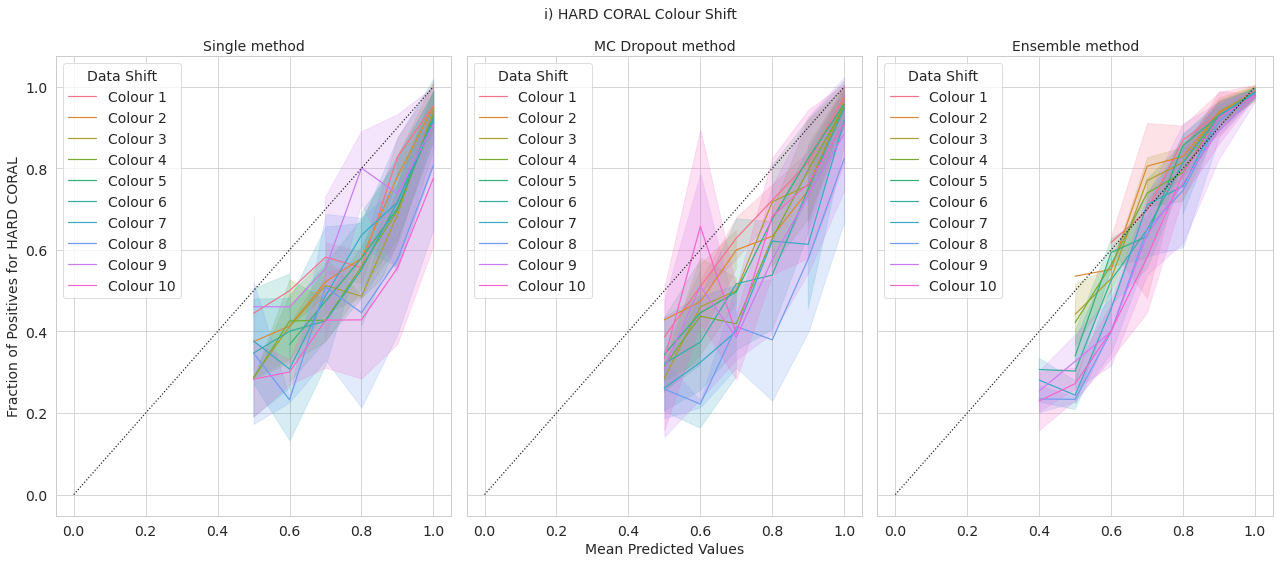

Shift Blur


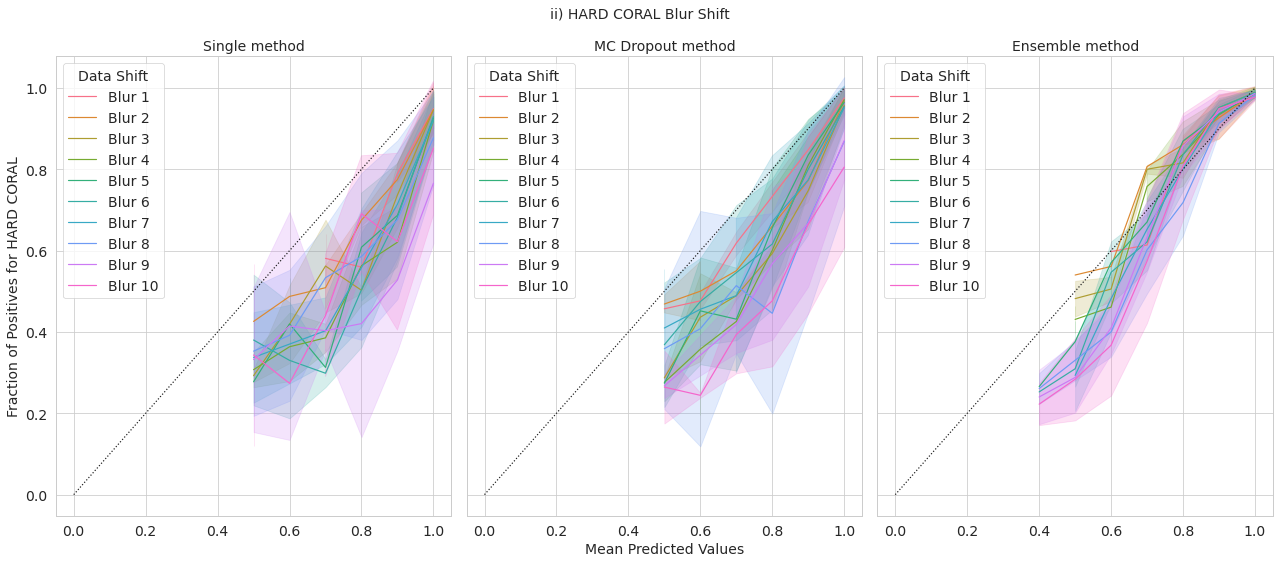

Shift Real


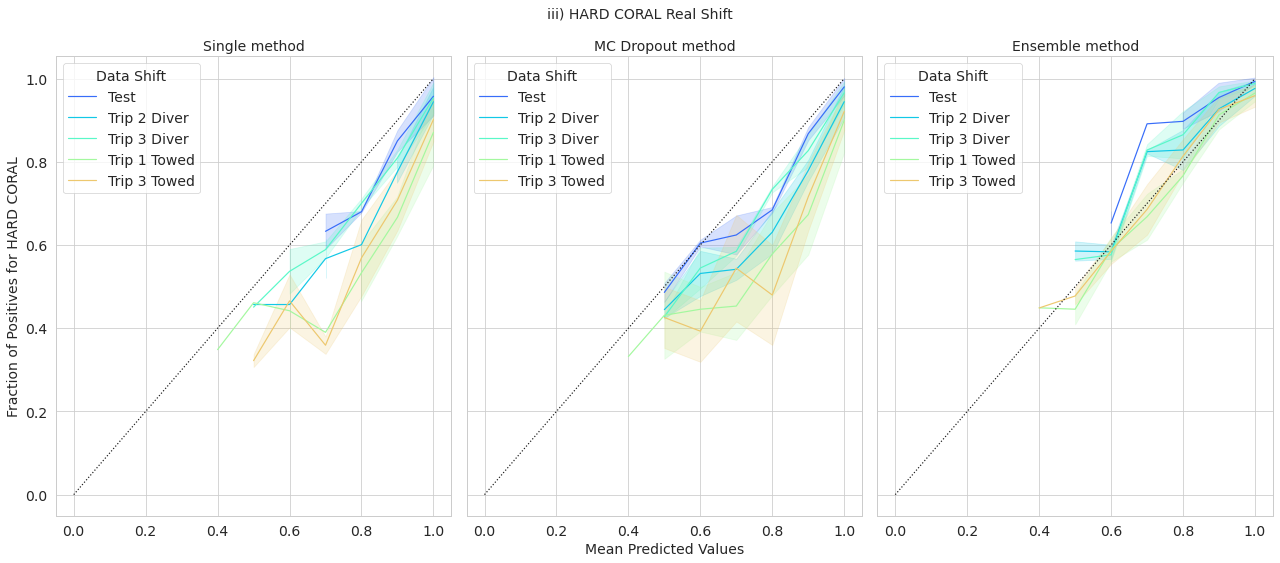

ALGAE
Shift Colour


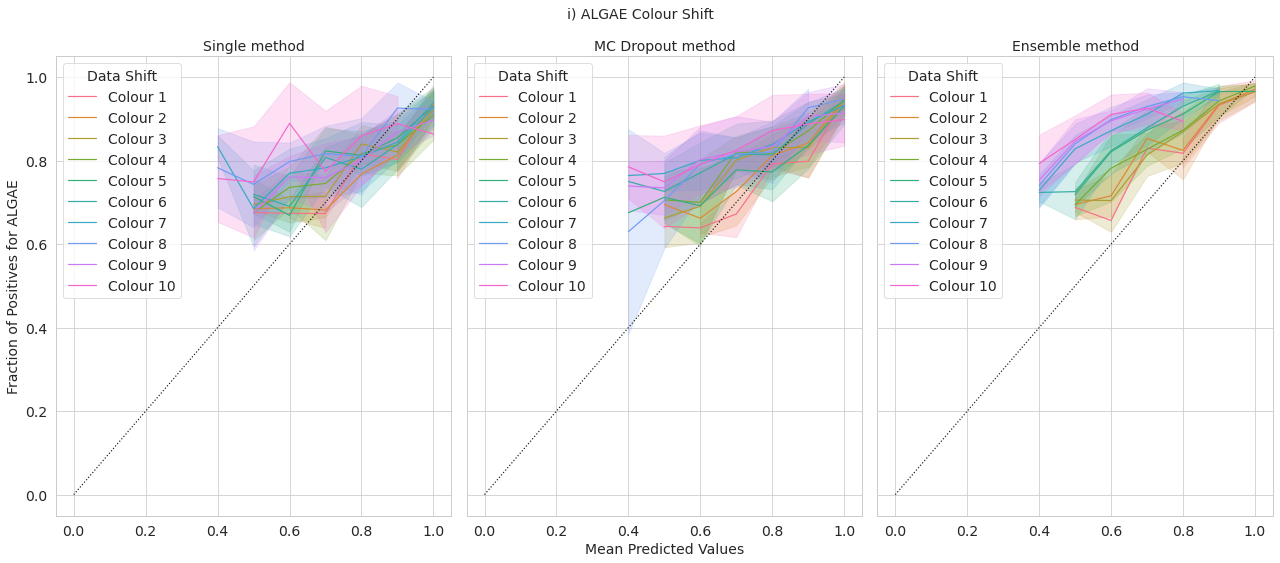

Shift Blur


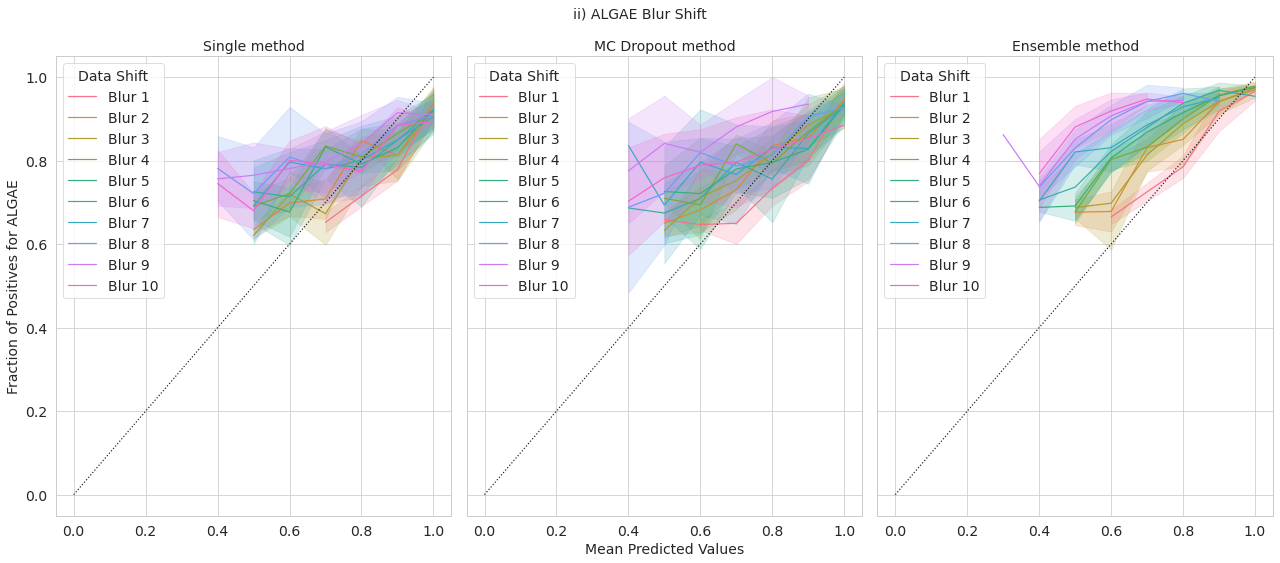

Shift Real


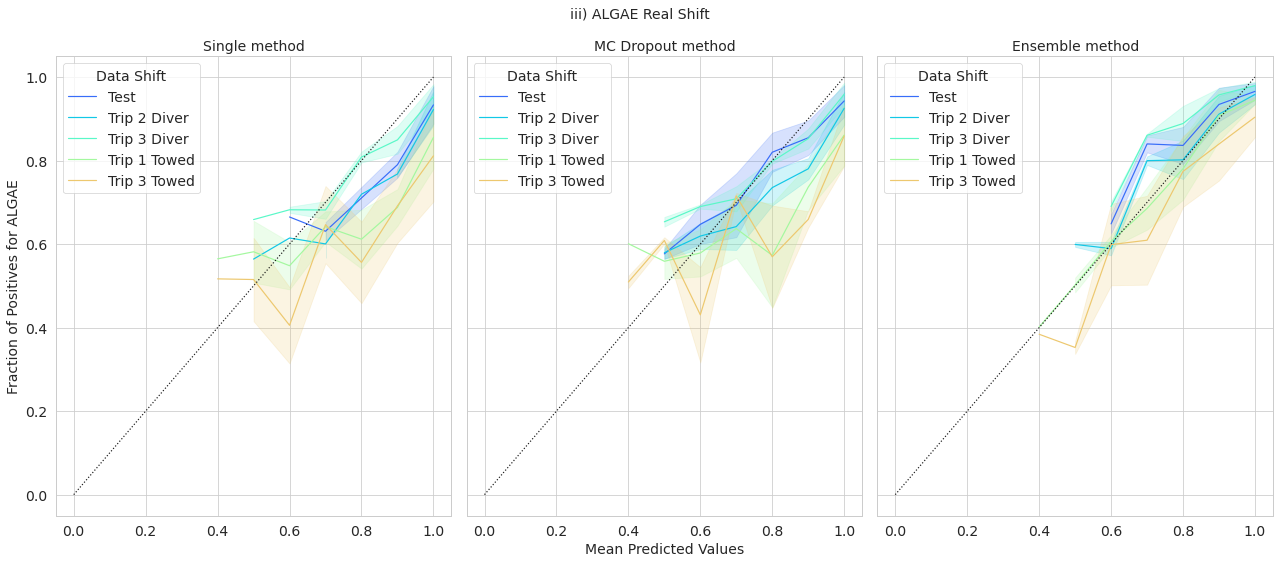

ABIOTIC
Shift Colour


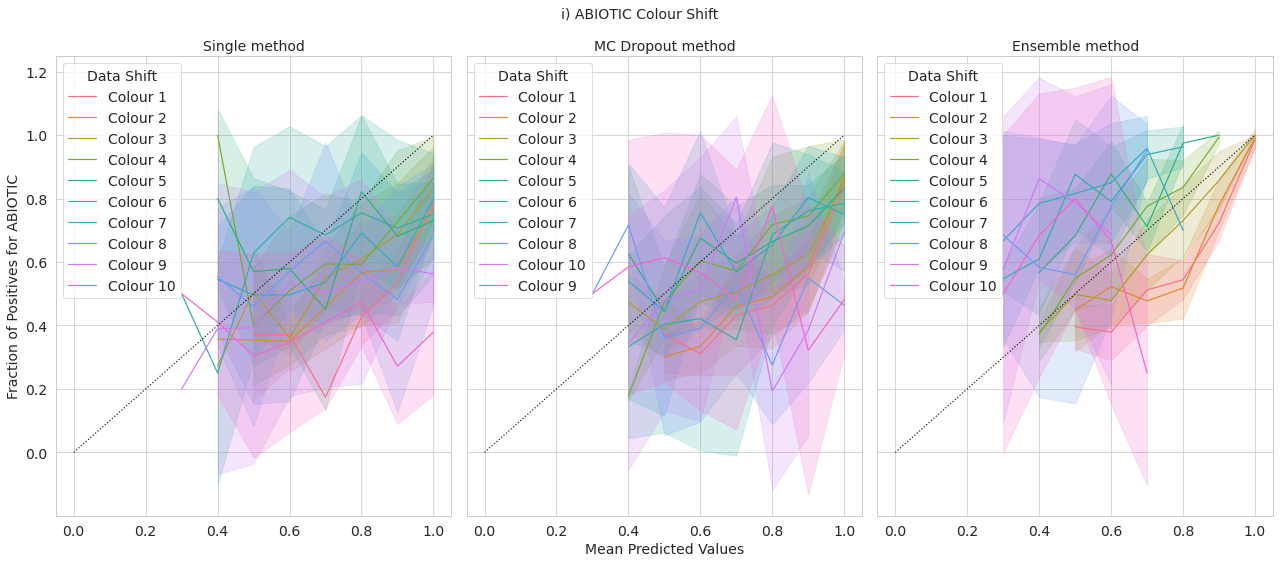

Shift Blur


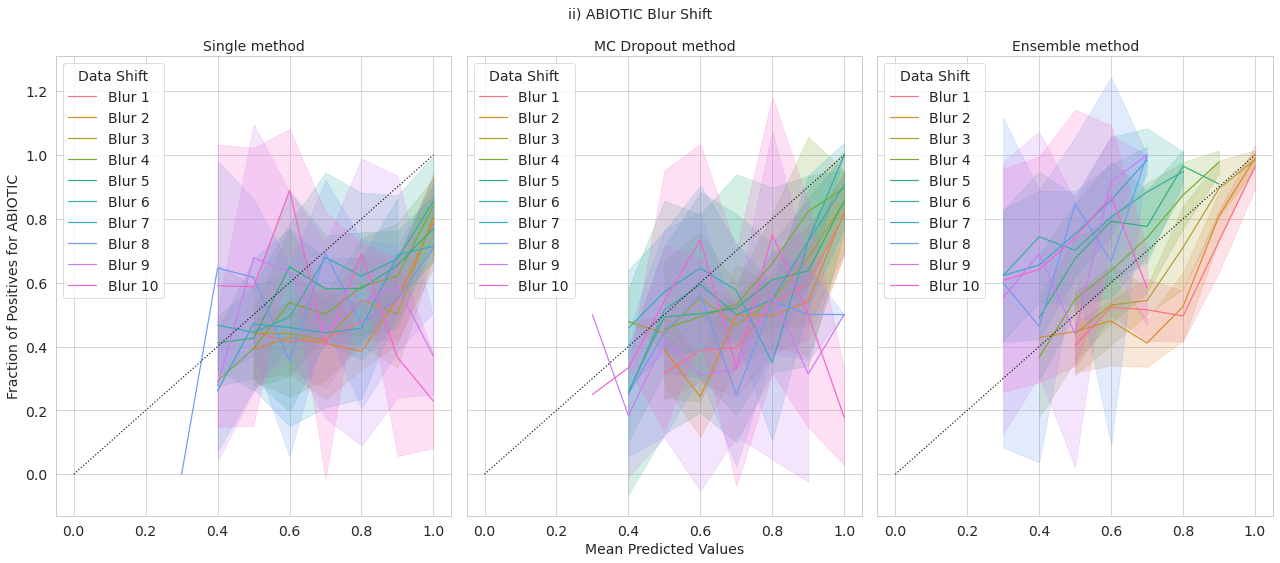

Shift Real


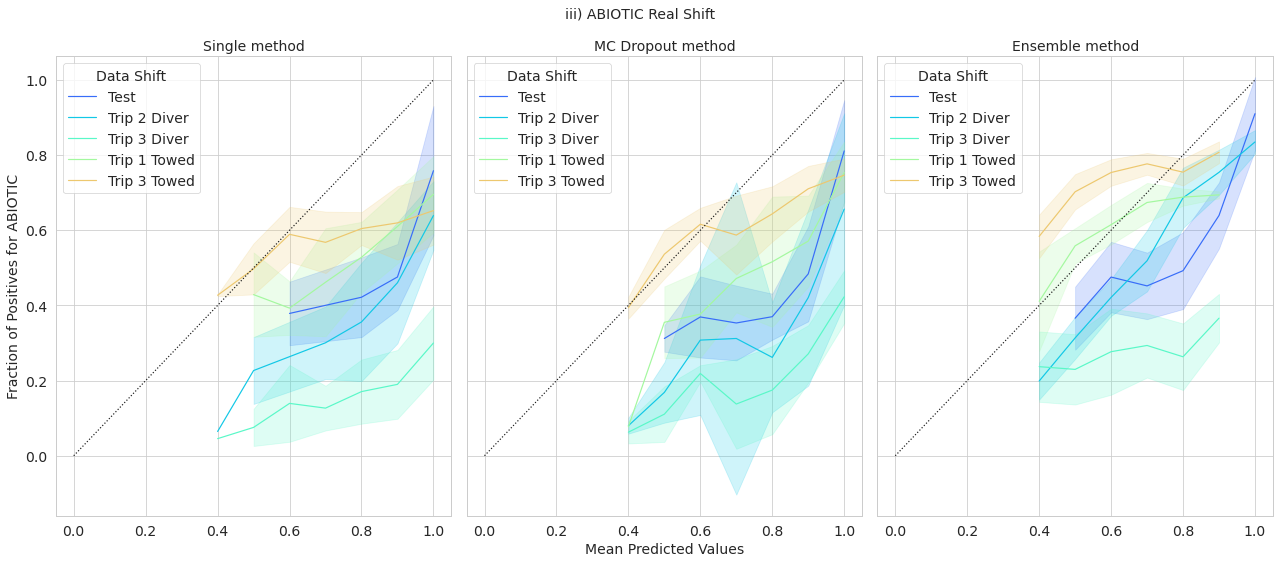

OTHER
Shift Colour


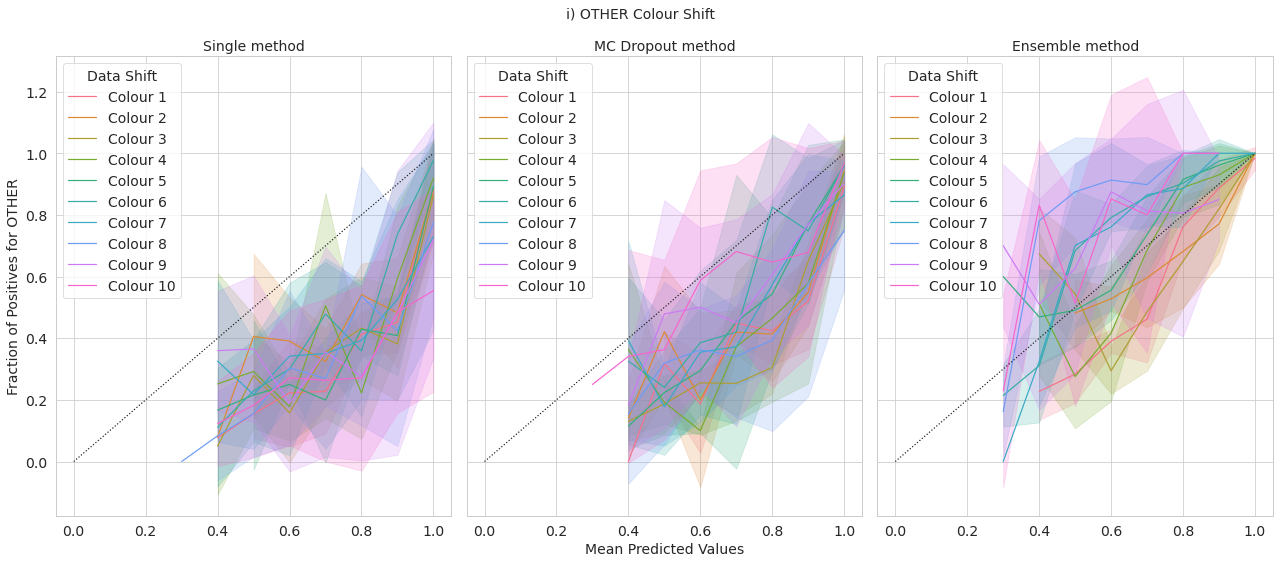

Shift Blur


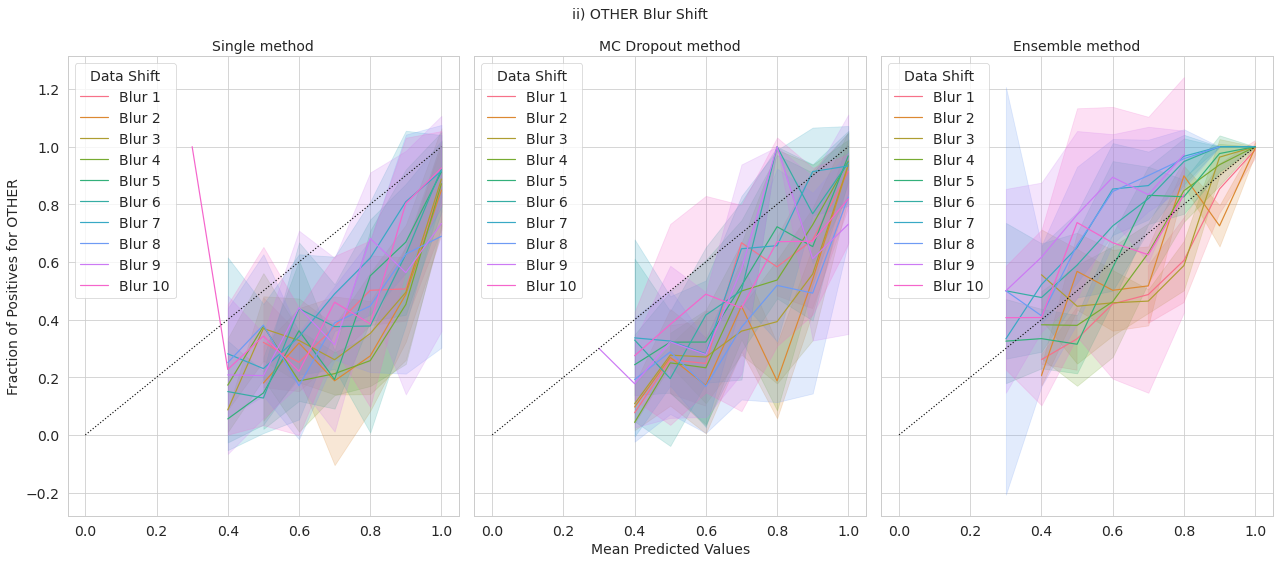

Shift Real


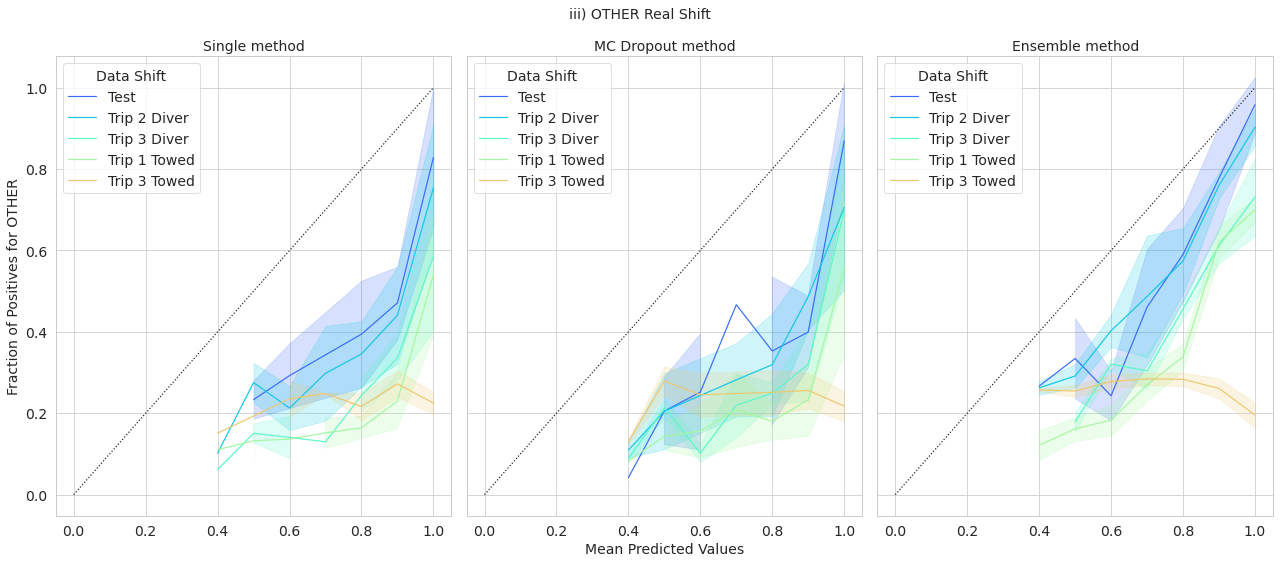

SOFT CORAL
Shift Colour


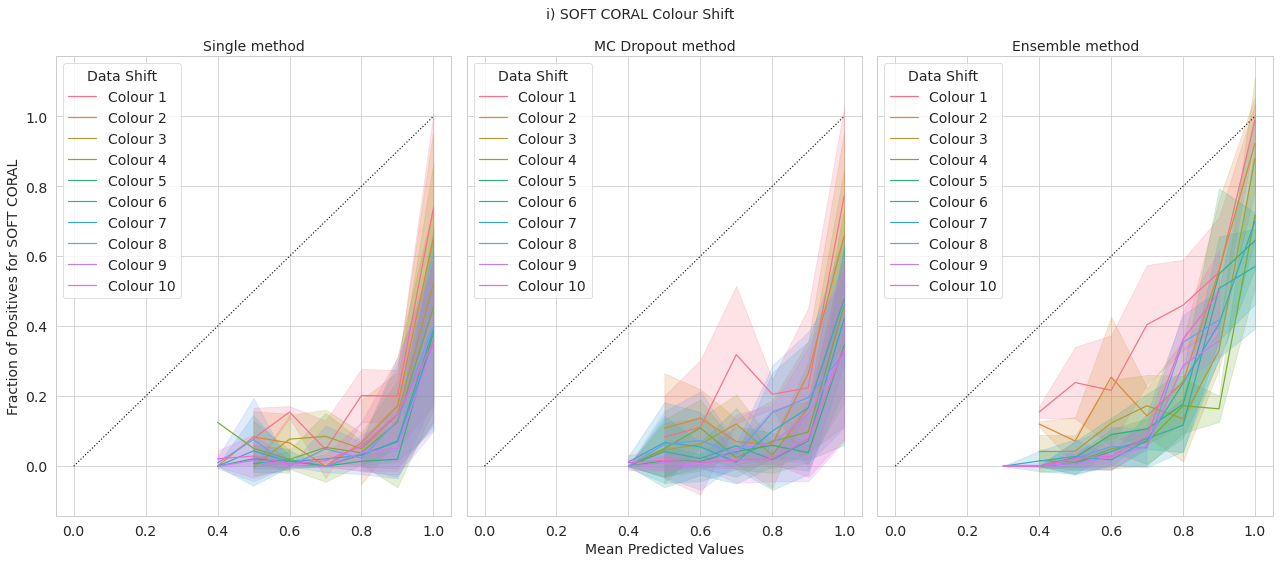

Shift Blur


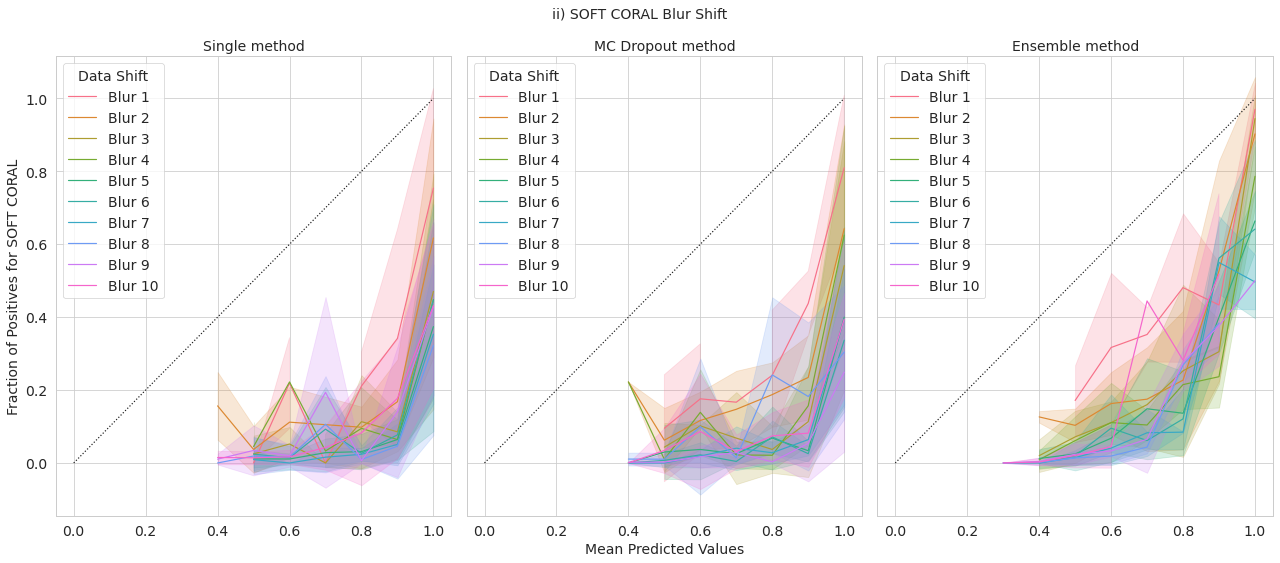

Shift Real


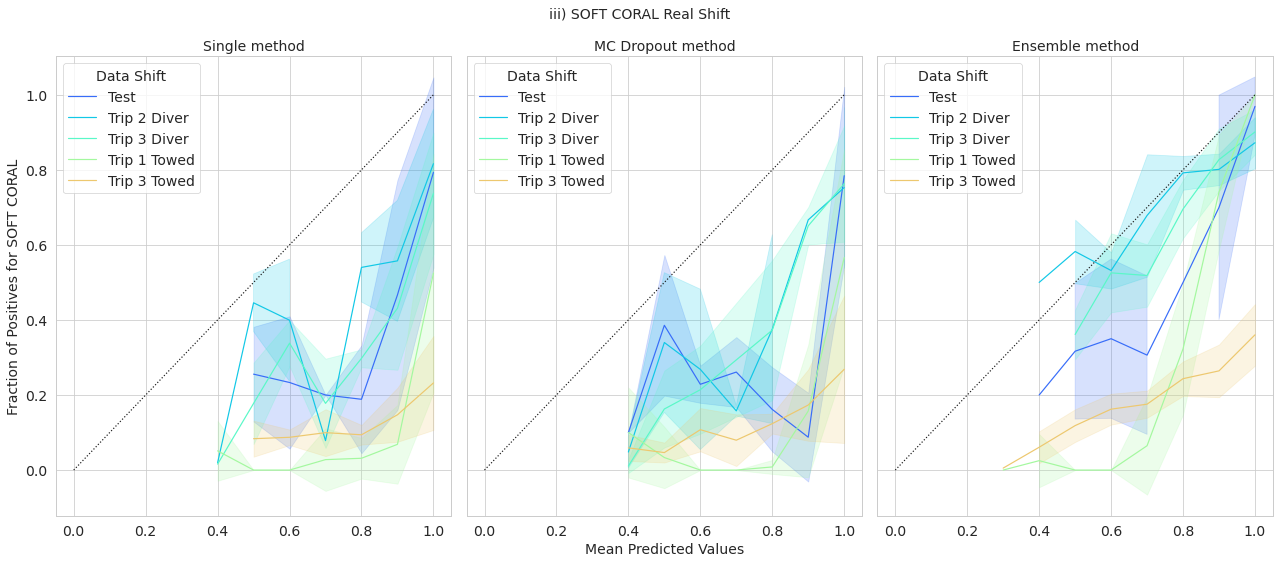

SPONGE
Shift Colour


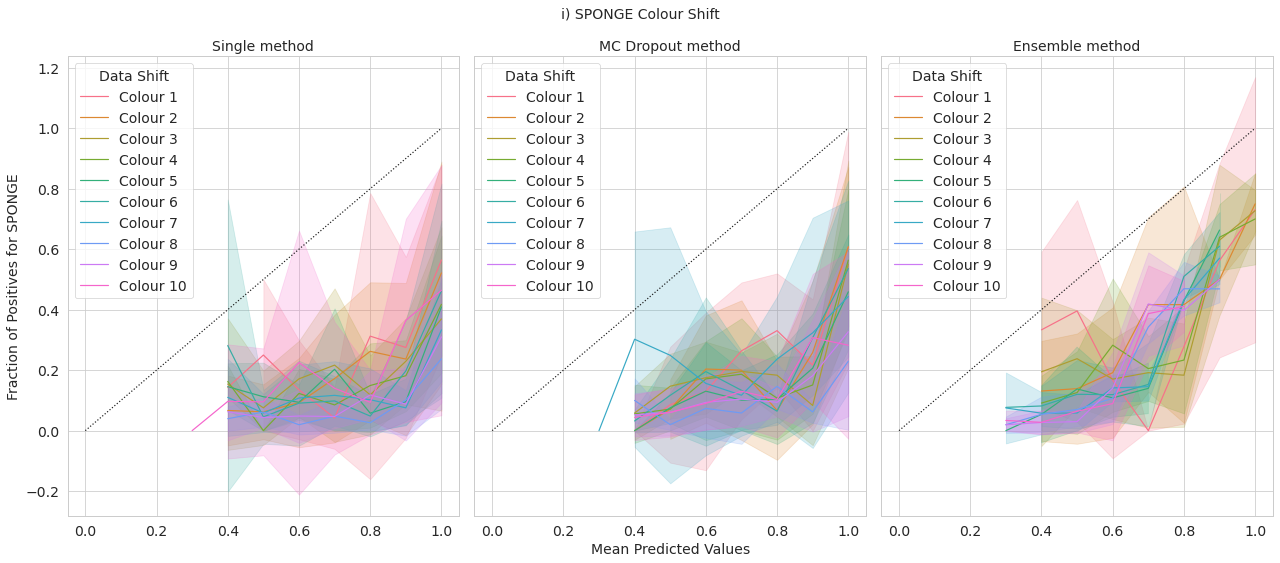

Shift Blur


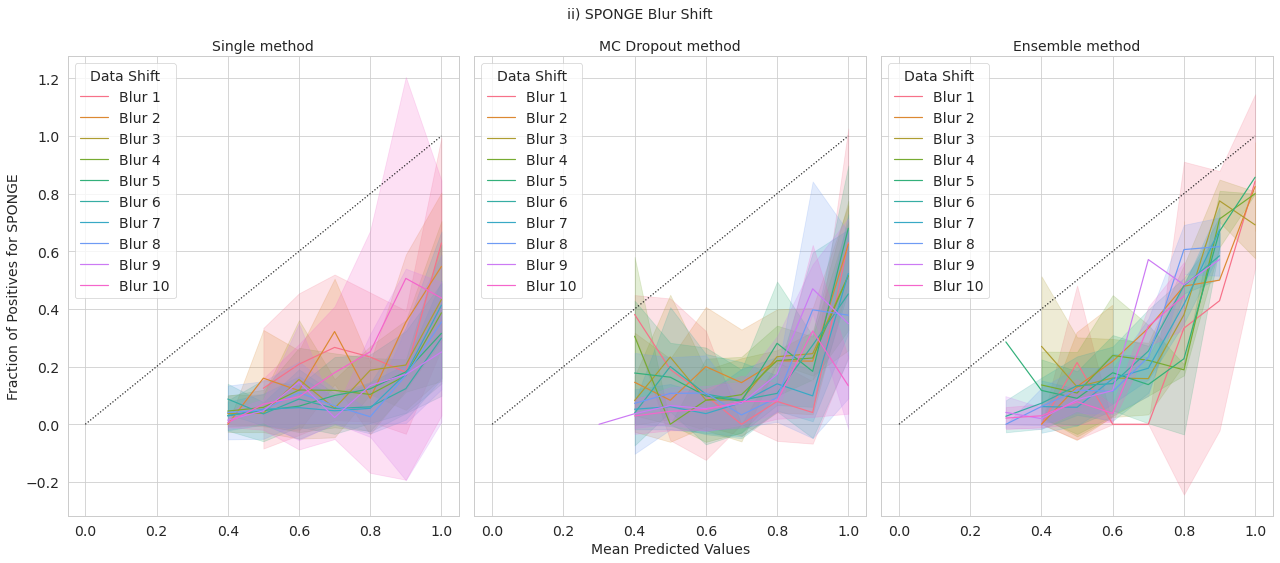

Shift Real


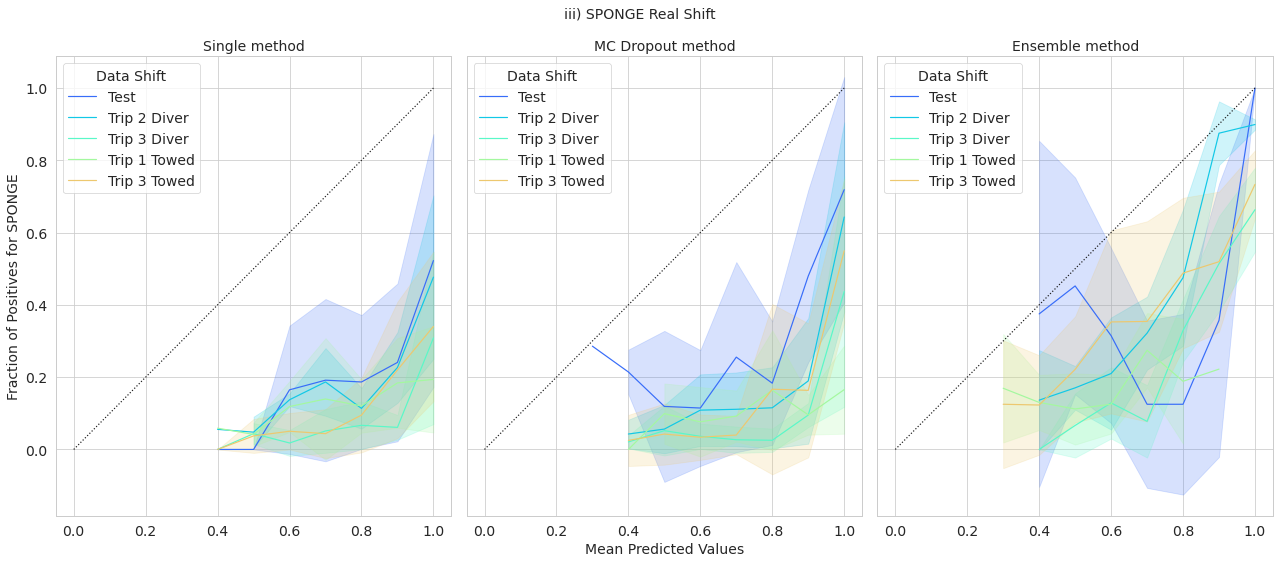

INDETERMINATE
Shift Colour


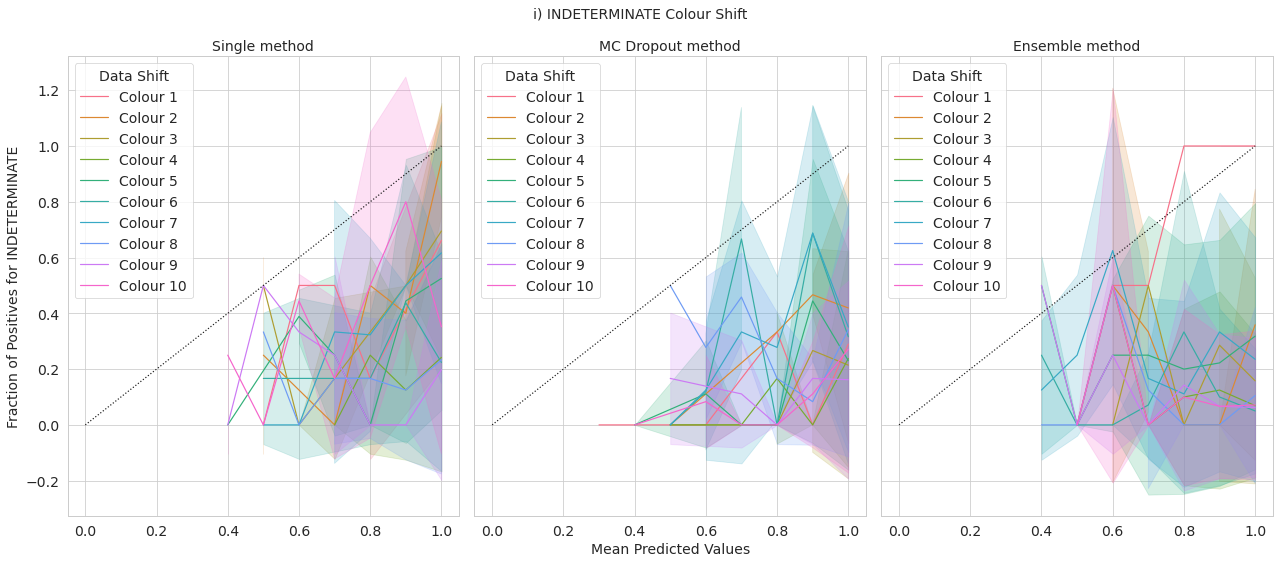

Shift Blur


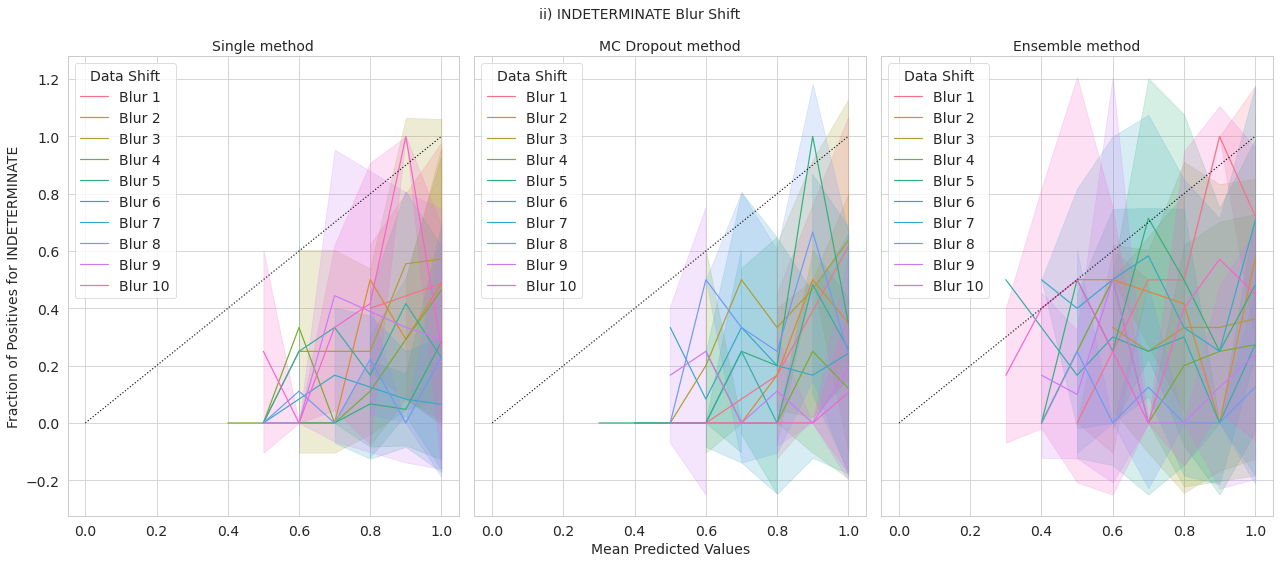

Shift Real


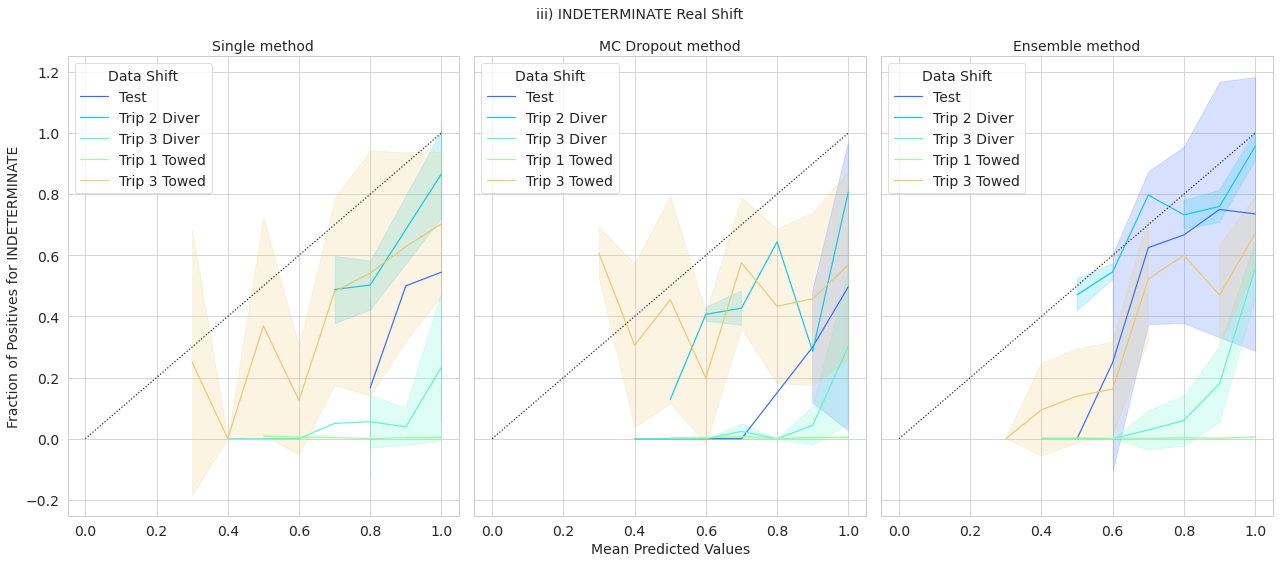

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

for label in df.prediction_label.unique():
    print(label)

    label_metrics_df = per_label_metrics_df[label]
    for index, shift in enumerate(np.flip(label_metrics_df['shift_category'].unique())):

        print("Shift", shift)

        b_plot_df = label_metrics_df[label_metrics_df['methods'].str.contains("MC Dropout")]
        e_plot_df = label_metrics_df[label_metrics_df['methods'].str.contains("Ensemble")]
        v_plot_df = label_metrics_df[label_metrics_df['methods'].str.contains("Single")]

        b_plot_df = b_plot_df[b_plot_df['shift_category'] == shift]
        e_plot_df = e_plot_df[e_plot_df['shift_category'] == shift]
        v_plot_df = v_plot_df[v_plot_df['shift_category'] == shift]

        sns.set_palette('rainbow')
        fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

        sub = sns.lineplot(data=v_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[0])
        sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        sub.set(xlabel='', ylabel='Fraction of Positives for %s' % label)
        sub.title.set_text('Single method')
        sub.get_legend().set_title("Data Shift")

        sub = sns.lineplot(data=b_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[1])
        sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        sub.set(xlabel='Mean Predicted Values', ylabel='Fraction of Positives for %s' % label)
        sub.title.set_text('MC Dropout method')
        sub.get_legend().set_title("Data Shift")
        #axes[1].set_title(label)

        sub = sns.lineplot(data=e_plot_df, x="mean_predicted_values", y="fraction_of_positives", hue="data_shifts", ci="sd", label="", ax=axes[2])
        sub.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        sub.set(xlabel='', ylabel='Fraction of Positives for %s' % label)
        sub.title.set_text('Ensemble method')
        sub.get_legend().set_title("Data Shift")
        
                
        fig = plt.gcf()
        
        fig.suptitle(int_to_roman(index+1) + ") " + label + " " + shift + " Shift", fontsize=14)
        
        plt.tight_layout()
        plt.show()
        #fig.savefig("colour_shift_calibration.eps", format="eps", dpi=1000)
        fig.savefig("colour_shift_calibration_%s_%s.png" % (label, shift), format="png", dpi=1000, bbox_inches = 'tight')
        fig.savefig("colour_shift_calibration_%s_%s.jpg" % (label, shift), format="jpg", dpi=150, bbox_inches = 'tight')

        # out put the value tables for the results write up

        #print("Single results")
        #print(v_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

        #print("MC Dropout results")
        #print(b_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

        #print("Ensemble results")
        #print(e_plot_df.groupby(["data_shifts", "mean_predicted_values"]).agg( {'fraction_of_positives':['mean','std']}))

# Plot global F1, Precision, Recall

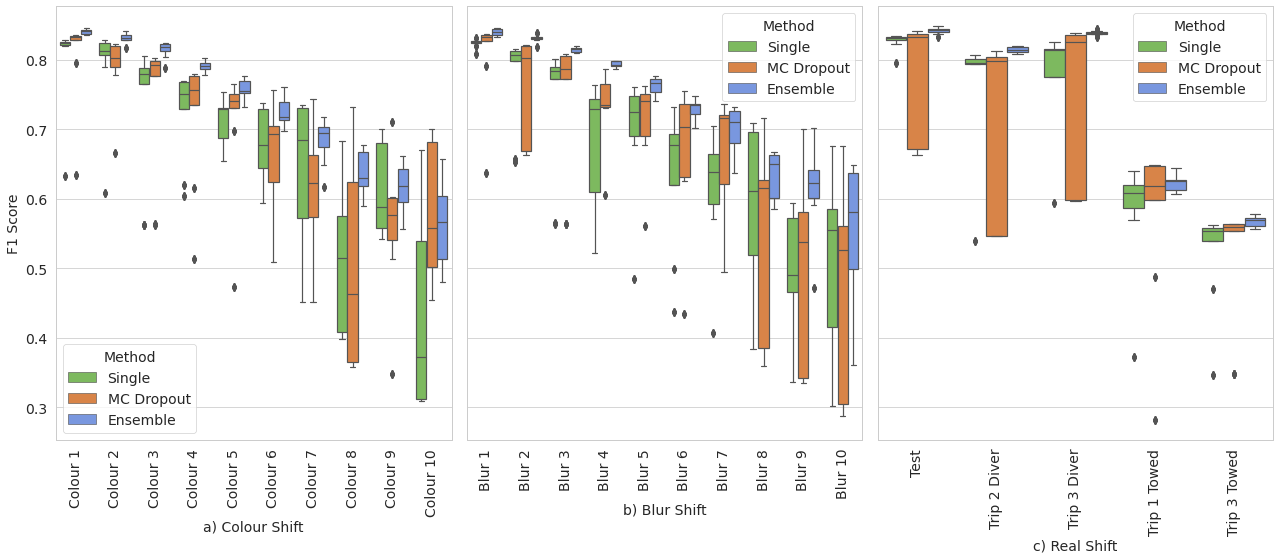

In [9]:
real = f1_scores_df[(f1_scores_df['shift_category'] == "Real") ]
colour = f1_scores_df[(f1_scores_df['shift_category'] == "Colour") ]
blur = f1_scores_df[(f1_scores_df['shift_category'] == "Blur") ]

'''

sns.set_palette('rainbow')

'''
# plot the boxplots in 3 cols
sns.set_style('whitegrid')
colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

sub = sns.boxplot(x="data_shift", y="f1_global", hue="method", data=colour, ax=axes[0], palette=colors)
sub.set(xlabel='a) Colour Shift', ylabel='F1 Score')
axes[0].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shift", y="f1_global", hue="method", data=blur, ax=axes[1], palette=colors)
sub.set(xlabel='b) Blur Shift', ylabel='')
axes[1].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

sub = sns.boxplot(x="data_shift", y="f1_global", hue="method", data=real, ax=axes[2], palette=colors)
sub.set(xlabel='c) Real Shift', ylabel='')
axes[2].tick_params(axis='x', rotation=90)
sub.get_legend().set_title("Method")

fig = plt.gcf()
fig.savefig("global_f1.pdf", format="pdf", dpi=1000)
#plt.legend()
plt.tight_layout()
plt.show()

# Plot F1s per class

HARD CORAL


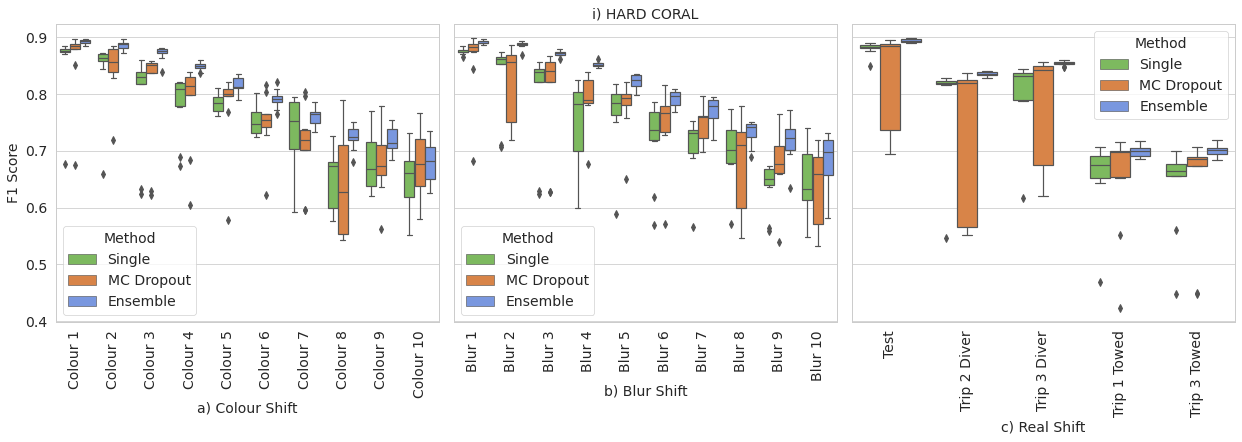

ALGAE


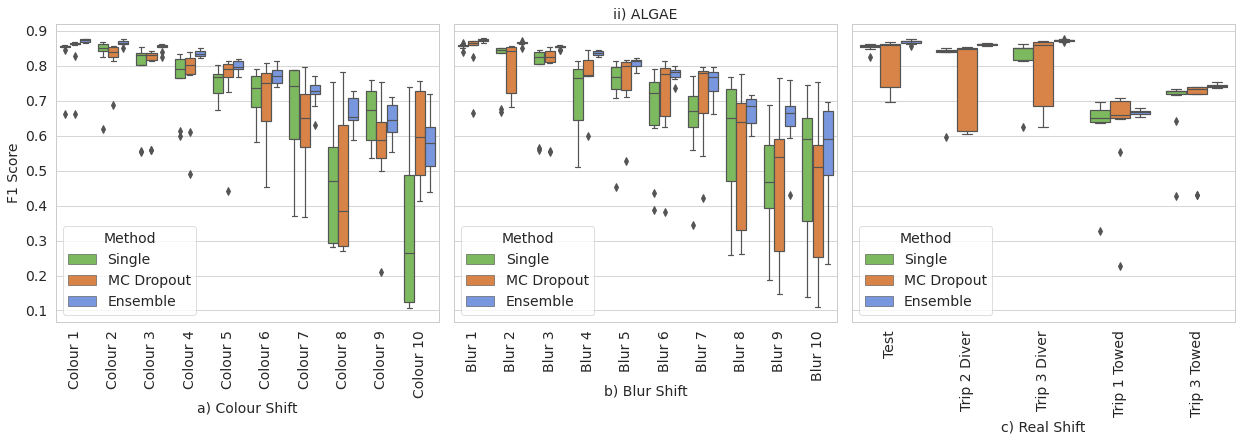

ABIOTIC


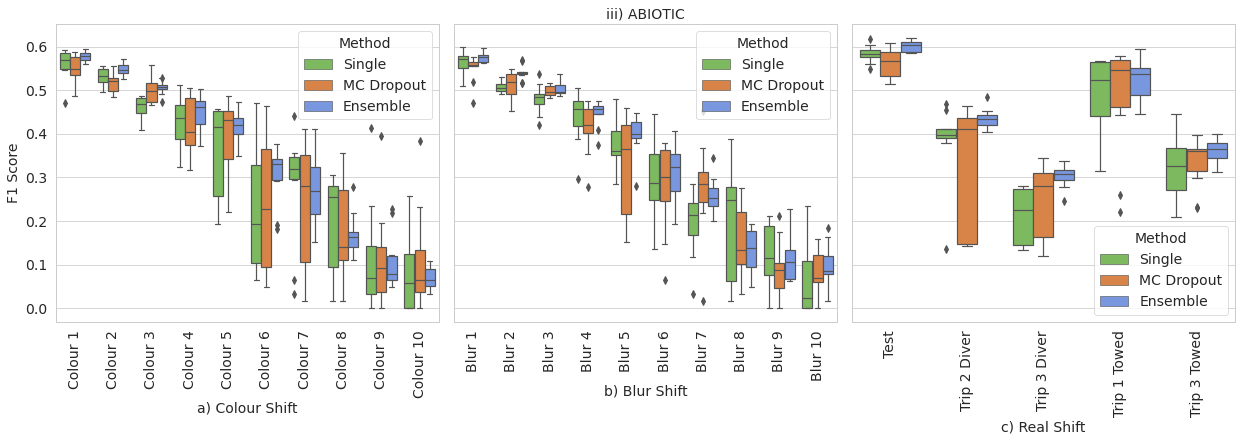

OTHER


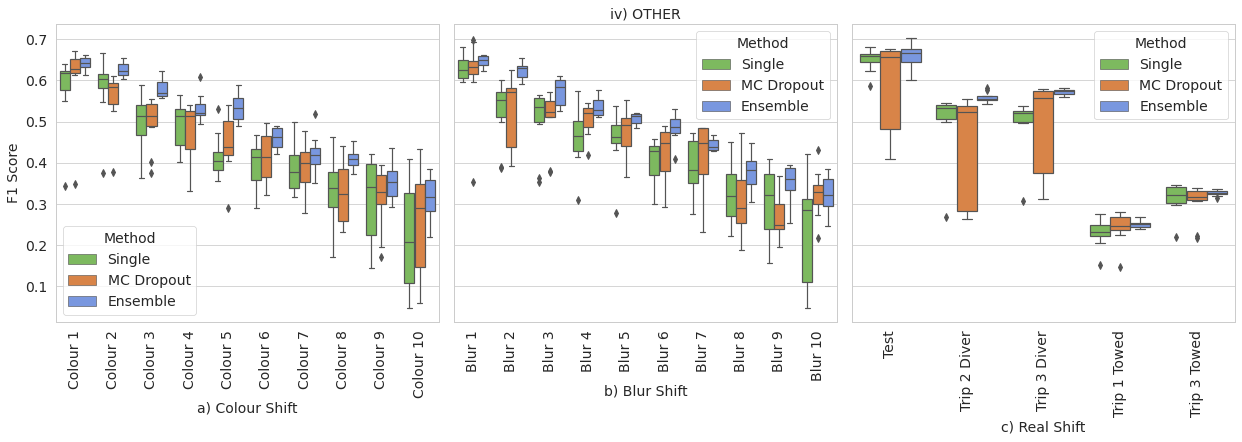

SOFT CORAL


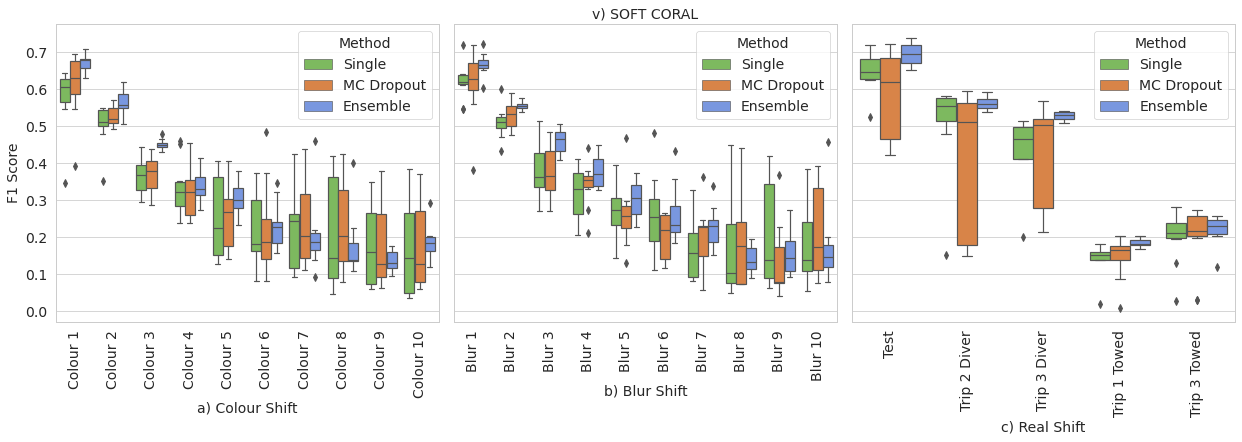

SPONGE


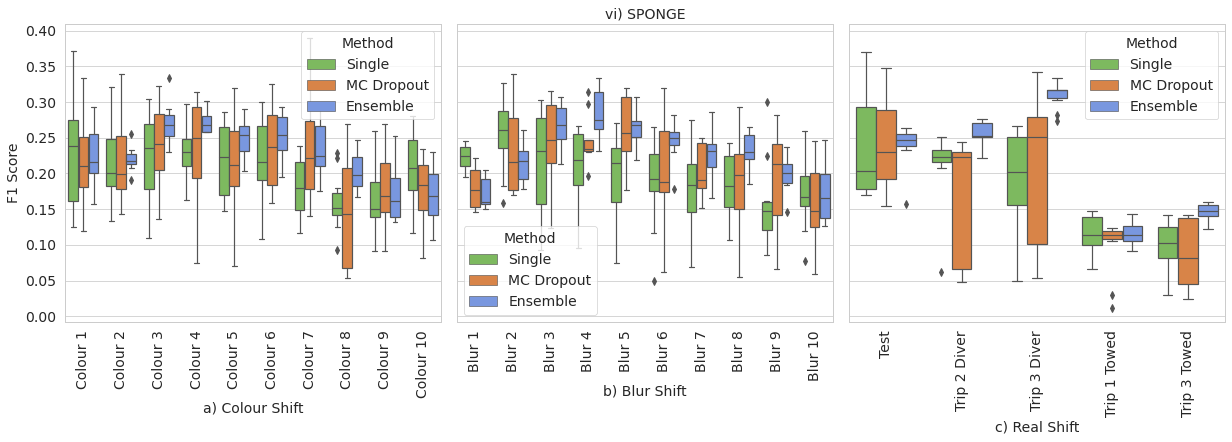

INDETERMINATE


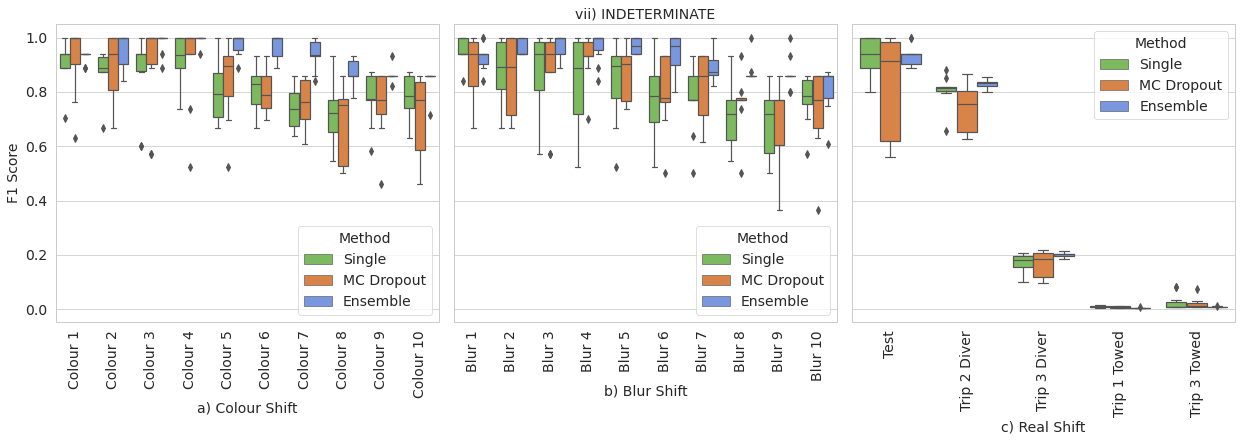

In [22]:

for index, label in enumerate(f1_scores_df.label.unique()):
    #    per_label_metrics_df[label].to_pickle("%s_metrics_df.p" % label)
    print(label)

    real = f1_scores_df[(f1_scores_df['shift_category'] == "Real") & (f1_scores_df["label"] == label)]
    colour = f1_scores_df[(f1_scores_df['shift_category'] == "Colour") & (f1_scores_df["label"] == label)]
    blur = f1_scores_df[(f1_scores_df['shift_category'] == "Blur") & (f1_scores_df["label"] == label)]

    '''

    sns.set_palette('rainbow')

    '''
    # plot the boxplots in 3 cols
    sns.set_style('whitegrid')
    colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(18,8))

    sub = sns.boxplot(x="data_shift", y="f1_labels", hue="method", data=colour, ax=axes[0], palette=colors)
    sub.set(xlabel='a) Colour Shift', ylabel='F1 Score')
    axes[0].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shift", y="f1_labels", hue="method", data=blur, ax=axes[1], palette=colors)
    sub.set(xlabel='b) Blur Shift', ylabel='')
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_title(int_to_roman(index+1) + ") " + label)
    sub.get_legend().set_title("Method")

    sub = sns.boxplot(x="data_shift", y="f1_labels", hue="method", data=real, ax=axes[2], palette=colors)
    sub.set(xlabel='c) Real Shift', ylabel='')
    axes[2].tick_params(axis='x', rotation=90)
    sub.get_legend().set_title("Method")
    
    
    
    fig = plt.gcf()
    fig.savefig("f1_%s.png" % label, format="png", dpi=1000, bbox_inches = 'tight')
    fig.savefig("f1_%s.jpg" % label, format="jpg", dpi=150, bbox_inches = 'tight')
    #plt.legend()
    plt.tight_layout()
    plt.show()

# explore results

In [40]:
for label in df.true_label.unique():
    new_df = df[(df['data_shift'] == "Test") & (df["true_label"] == label) & (df["method"] == "Single") & (df["run_name"] == "6854 Test DESC2 Vanilla 1")]
    print(label, len(new_df.index))

HARD CORAL 704
SPONGE 30
ALGAE 948
ABIOTIC 120
OTHER 64
SOFT CORAL 22
INDETERMINATE 8


In [58]:
df['data_shift'].str.contains("Col")

sub_df = df[df["run_name"].str.contains("Vanilla1")]
for run_name in sub_df.run_name.unique():
    print("-->", run_name)
    for label in sub_df.true_label.unique():
        new_df = sub_df[(sub_df["true_label"] == label) & (sub_df["method"] == "Single") & (sub_df["run_name"] == run_name)]
        print(label, len(new_df.index))

--> 6854 Trip6999 DESC2 Vanilla1
ALGAE 4726
OTHER 492
HARD CORAL 3815
SPONGE 85
SOFT CORAL 181
INDETERMINATE 320
ABIOTIC 211
--> 6854 Trip7255 DESC2 Vanilla1
ALGAE 5224
OTHER 429
HARD CORAL 3891
SPONGE 22
SOFT CORAL 153
INDETERMINATE 19
ABIOTIC 92
--> 6854 Trip6854SLO DESC2 Vanilla1
ALGAE 4038
OTHER 550
HARD CORAL 2892
SPONGE 102
SOFT CORAL 36
INDETERMINATE 14
ABIOTIC 1133
--> 6854 Trip7255SLO DESC2 Vanilla1
ALGAE 8615
OTHER 2158
HARD CORAL 6611
SPONGE 90
SOFT CORAL 249
INDETERMINATE 2110
ABIOTIC 2692
--> 6854 Trip6999 DESC2 Vanilla10
ALGAE 4726
OTHER 492
HARD CORAL 3815
SPONGE 85
SOFT CORAL 181
INDETERMINATE 320
ABIOTIC 211
--> 6854 Trip7255 DESC2 Vanilla10
ALGAE 5224
OTHER 429
HARD CORAL 3891
SPONGE 22
SOFT CORAL 153
INDETERMINATE 19
ABIOTIC 92
--> 6854 Trip6854SLO DESC2 Vanilla10
ALGAE 4038
OTHER 550
HARD CORAL 2892
SPONGE 102
SOFT CORAL 36
INDETERMINATE 14
ABIOTIC 1133
--> 6854 Trip7255SLO DESC2 Vanilla10
ALGAE 8615
OTHER 2158
HARD CORAL 6611
SPONGE 90
SOFT CORAL 249
INDETERMINATE 

In [49]:
df.run_name.unique()

array(['6854 Test DESC2 Vanilla 1', '6854 Test DESC2 Vanilla 2',
       '6854 Test DESC2 Vanilla 3', '6854 Test DESC2 Vanilla 4',
       '6854 Test DESC2 Vanilla 5', '6854 Test DESC2 Vanilla 6',
       '6854 Test DESC2 Vanilla 7', '6854 Test DESC2 Vanilla 8',
       '6854 Test DESC2 Vanilla 9', '6854 Test DESC2 Vanilla 10',
       '6854 Trip6999 DESC2 Vanilla1', '6854 Trip7255 DESC2 Vanilla1',
       '6854 Trip6854SLO DESC2 Vanilla1',
       '6854 Trip7255SLO DESC2 Vanilla1', '6854 Trip6999 DESC2 Vanilla2',
       '6854 Trip7255 DESC2 Vanilla2', '6854 Trip6854SLO DESC2 Vanilla2',
       '6854 Trip7255SLO DESC2 Vanilla2', '6854 Trip6999 DESC2 Vanilla3',
       '6854 Trip7255 DESC2 Vanilla3', '6854 Trip6854SLO DESC2 Vanilla3',
       '6854 Trip7255SLO DESC2 Vanilla3', '6854 Trip6999 DESC2 Vanilla4',
       '6854 Trip7255 DESC2 Vanilla4', '6854 Trip6854SLO DESC2 Vanilla4',
       '6854 Trip7255SLO DESC2 Vanilla4', '6854 Trip6999 DESC2 Vanilla5',
       '6854 Trip7255 DESC2 Vanilla5', '685

ValueError: cannot reindex from a duplicate axis

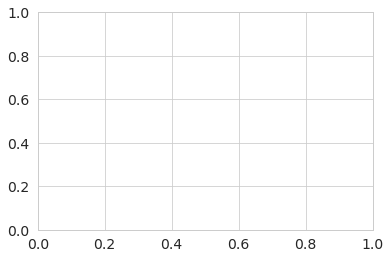

In [31]:
sns.histplot(data=new_df, x="prediction_score", bins=10)

In [37]:
len(new_df.index)

300

In [39]:
new_df.run_name.unique()

array(['6854 Test DESC2 Vanilla 1', '6854 Test DESC2 Vanilla 2',
       '6854 Test DESC2 Vanilla 3', '6854 Test DESC2 Vanilla 4',
       '6854 Test DESC2 Vanilla 5', '6854 Test DESC2 Vanilla 6',
       '6854 Test DESC2 Vanilla 7', '6854 Test DESC2 Vanilla 8',
       '6854 Test DESC2 Vanilla 9', '6854 Test DESC2 Vanilla 10'],
      dtype=object)